# **Customer Churn Prediction and Retention Strategies**

## **WorkFlow of the Project**

<ul>
    <li>Data Loading</li>
    <li>Exploratory Data Analysis (E.D.A.)</li>
    <li>Data Preprocessing</li>
    <li>Machine Learning Model Developments</li>
    <li>Model Evaluation</li>
    <li>Conclusion</li>
</ul>

## Importing the Libraries

In [1]:
# Print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Library for Warning Message
import warnings
warnings.simplefilter("ignore")

# Base Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Libraries for ML Parameters
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GridSearchCV

# Libraries for ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Libraries for Performance Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, precision_recall_curve

## Data Loading

In [3]:
# We have 2 separate datasets for training and test set.
df_train = pd.read_csv("customer_churn_dataset_training.csv")
df_test = pd.read_csv("customer_churn_dataset_testing.csv")

## Exploratory Data Analysis (E.D.A.)

Since we have separate datasets for training and testing, we will conduct Exploratory Data Analysis (EDA) on the training data, while the performance of the best machine learning models will be evaluated using the test data.

In [5]:
# Glimpse of the first 5 rows
print("Glimpse of the first 5 rows")
print(" ")
df_train.head()

Glimpse of the first 5 rows
 


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [7]:
# Converting the Column Names to "LowerCase"
df_train.columns = df_train.columns.str.lower()

# Verify
df_train.head(1)

,customerid,age,gender,tenure,usage frequency,support calls,payment delay,subscription type,contract length,total spend,last interaction,churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0


In [9]:
# Setting the "customerid" column as Index
df_train = df_train.set_index("customerid")

# Verify
df_train.head(1)

,age,gender,tenure,usage frequency,support calls,payment delay,subscription type,contract length,total spend,last interaction,churn
customerid,,,,,,,,,,,
2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0


In [11]:
# Dimension of the Data
print("Dimension of the Data")
print(" ")
print("The dataset consists of {} rows and {} columns, with 'customerid' set as the index column.".format(
        df_train.shape[0], df_train.shape[1]+1))

Dimension of the Data
 
The dataset consists of 440833 rows and 12 columns, with 'customerid' set as the index column.


In [13]:
# Checking of Missing Values
print("Checking of Missing Values")
print(" ")

if df_train.isna().sum().sum() == 0:
    print("The data has no missing values")
else:
    print("The data has {} missing values in total.".format(df_train.isna().sum().sum()))

Checking of Missing Values
 
The data has 11 missing values in total.


In [15]:
# Verify which column(s) has missing values
df_train[df_train.isna().any(axis = 1)]

,age,gender,tenure,usage frequency,support calls,payment delay,subscription type,contract length,total spend,last interaction,churn
customerid,,,,,,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Only 1 row has no data. Therefore, we can remove it from our dataset.

In [17]:
# Removing the missing row
df_train.dropna(inplace = True)

# Final Dimension
print("After removing the row with missing values, the final data consists of {} rows and {} columns (incl. index column).".format(
    df_train.shape[0], df_train.shape[1]+1))

After removing the row with missing values, the final data consists of 440832 rows and 12 columns (incl. index column).


### **Data Description**

**Customer Demographics:**
<ul>
    <li>Age</li>
    <li>Gender</li>
</ul>

**Engagement Metrics:**
<ul>
    <li>Tenure</li>
    <li>Usage Frequency</li>
    <li>Support Calls</li>
</ul>

**Payment Behavior:**
<ul>
    <li>Payment Delay</li>
    <li>Total Spend</li>
</ul>

**Subscription Details**
<ul>
    <li>Subscription Type</li>
    <li>Contract Length</li>
</ul>

**Customer Interaction:**
<ul>
    <li>Last Interaction</li>
</ul>

**Target Variable:**
<ul>
    <li>Churn (Binary indicator of whether a customer left)</li>
</ul>

In [19]:
# Check the Data Types of each variables
df_train.info()
print(" ")

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 2.0 to 449999.0
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   age                440832 non-null  float64
 1   gender             440832 non-null  object 
 2   tenure             440832 non-null  float64
 3   usage frequency    440832 non-null  float64
 4   support calls      440832 non-null  float64
 5   payment delay      440832 non-null  float64
 6   subscription type  440832 non-null  object 
 7   contract length    440832 non-null  object 
 8   total spend        440832 non-null  float64
 9   last interaction   440832 non-null  float64
 10  churn              440832 non-null  float64
dtypes: float64(8), object(3)
memory usage: 40.4+ MB
 


Now, columns like **age, tenure, support calls, churn, etc.** should be describe as integer and not as float.

In [21]:
# Convert the Numeric columns to integer

float_cols = ["age", "tenure", "usage frequency", "support calls", "payment delay", "last interaction", "churn"]

df_train[float_cols] = df_train[float_cols].astype("int")

In [23]:
# Convert the index to Integer
df_train.index = df_train.index.astype("int")

In [25]:
# Verify the Data Type
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 2 to 449999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   age                440832 non-null  int64  
 1   gender             440832 non-null  object 
 2   tenure             440832 non-null  int64  
 3   usage frequency    440832 non-null  int64  
 4   support calls      440832 non-null  int64  
 5   payment delay      440832 non-null  int64  
 6   subscription type  440832 non-null  object 
 7   contract length    440832 non-null  object 
 8   total spend        440832 non-null  float64
 9   last interaction   440832 non-null  int64  
 10  churn              440832 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 40.4+ MB


In [27]:
# View the data
df_train.head()

,age,gender,tenure,usage frequency,support calls,payment delay,subscription type,contract length,total spend,last interaction,churn
customerid,,,,,,,,,,,
2,30,Female,39,14,5,18,Standard,Annual,932.0,17,1
3,65,Female,49,1,10,8,Basic,Monthly,557.0,6,1
4,55,Female,14,4,6,18,Basic,Quarterly,185.0,3,1
5,58,Male,38,21,7,7,Standard,Monthly,396.0,29,1
6,23,Male,32,20,5,8,Basic,Monthly,617.0,20,1


#### **Do we have Duplicate Customers?**

In [29]:
is_duplicate_customer = df_train.index.duplicated().any()

if is_duplicate_customer == True:
    print("There are duplicate customer present in the dataset.")
else:
    print("The dataset has no duplicate customers.")

The dataset has no duplicate customers.


In [31]:
# Check the unique values from Categorical Columns
print("Gender has {} unique values and they are {}.".format(df_train.gender.nunique(), df_train.gender.unique()))
print(" ")
print("Subscription Type has {} unique values and they are {}.".format(df_train["subscription type"].nunique(), df_train["subscription type"].unique()))
print(" ")
print("Contract Length has {} unique values and they are {}.".format(df_train["contract length"].nunique(), df_train["contract length"].unique()))

Gender has 2 unique values and they are ['Female' 'Male'].
 
Subscription Type has 3 unique values and they are ['Standard' 'Basic' 'Premium'].
 
Contract Length has 3 unique values and they are ['Annual' 'Monthly' 'Quarterly'].


<Figure size 1500x1000 with 0 Axes>

<Axes: >

<Axes: xlabel='age', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of age')

<Axes: >

<Axes: xlabel='tenure', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of tenure')

<Axes: >

<Axes: xlabel='usage frequency', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of usage frequency')

<Axes: >

<Axes: xlabel='support calls', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of support calls')

<Axes: >

<Axes: xlabel='payment delay', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of payment delay')

<Axes: >

<Axes: xlabel='total spend', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of total spend')

<Axes: >

<Axes: xlabel='last interaction', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of last interaction')

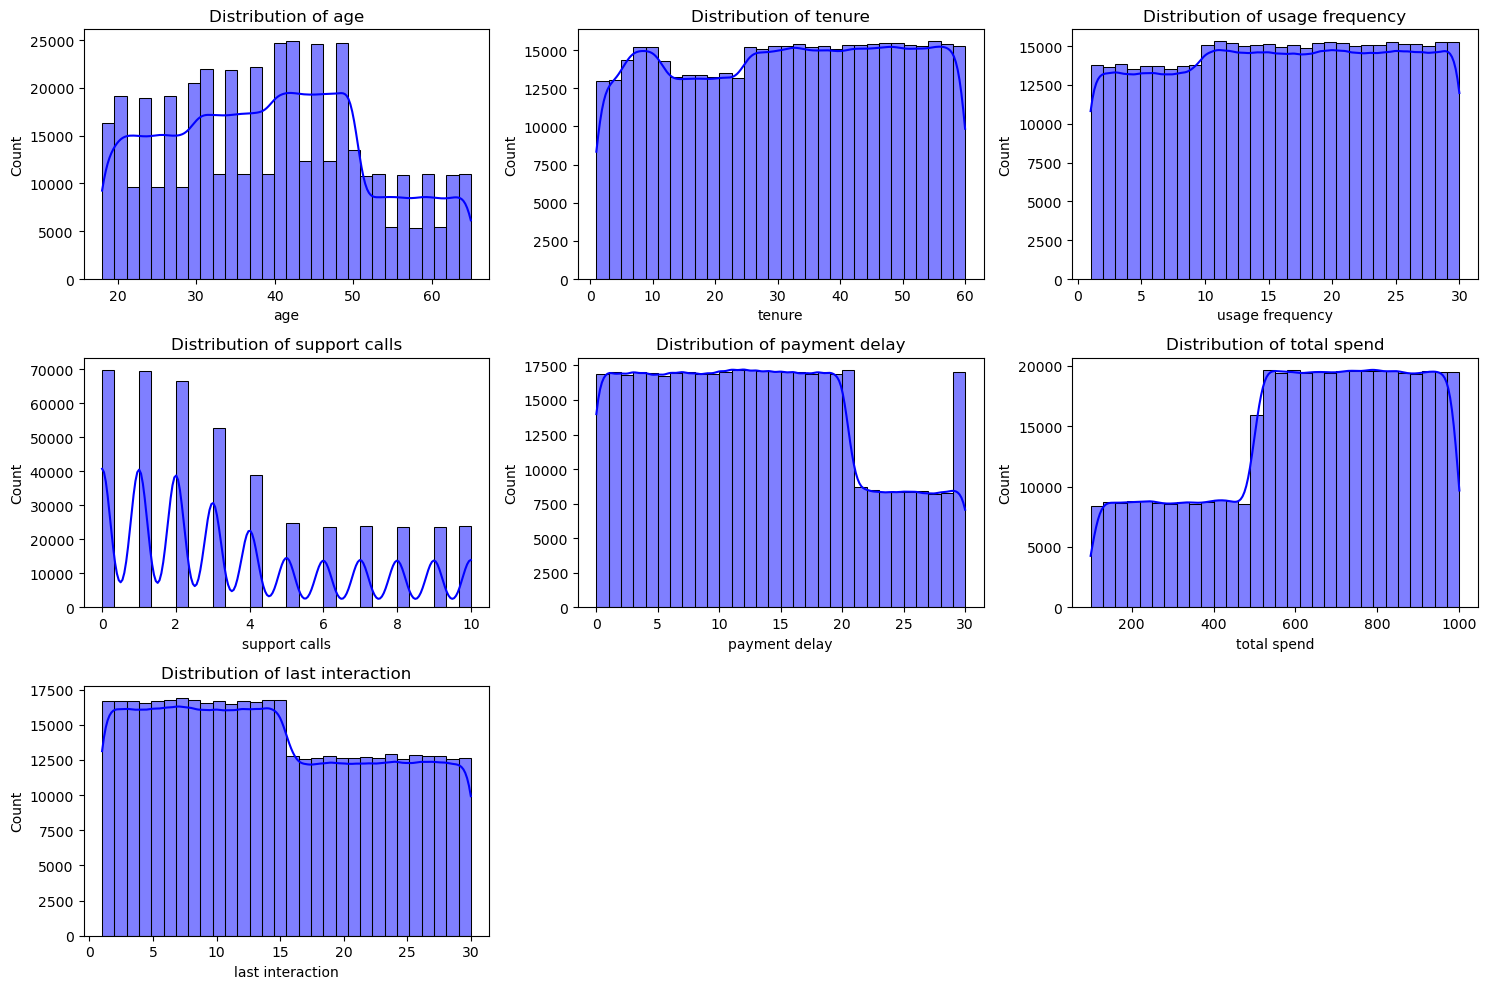

In [33]:
# Plot the distribution for numeric columns
col_num = ['age', 'tenure', 'usage frequency', 'support calls', 'payment delay', 'total spend', 'last interaction']


plt.figure(figsize=(15, 10))
for i, col in enumerate(col_num, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_train[col], bins=30, kde=True, color='blue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

<Axes: xlabel='subscription type', ylabel='count'>

Text(0.5, 1.0, 'Customer Churn Distribution by subscription type')

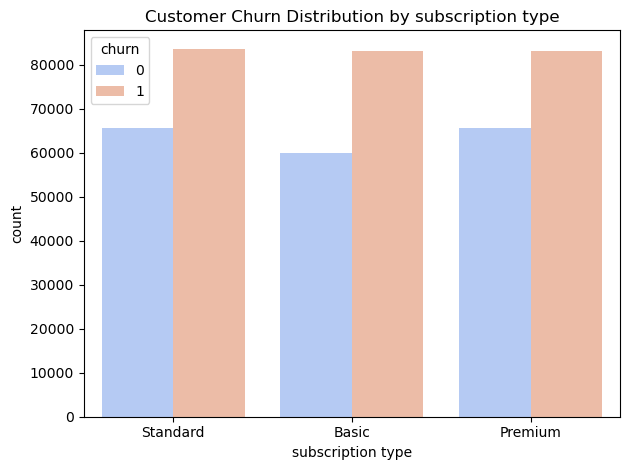

<Axes: xlabel='contract length', ylabel='count'>

Text(0.5, 1.0, 'Customer Churn Distribution by contract length')

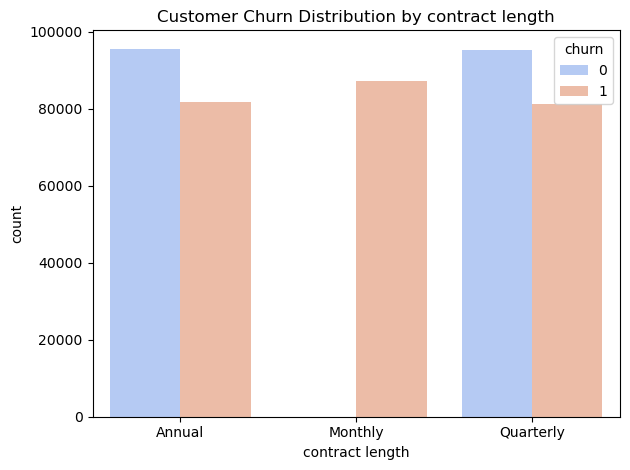

<Axes: xlabel='churn', ylabel='total spend'>

Text(0.5, 1.0, 'Average total spend between Churn Vs Not Churn Customers')

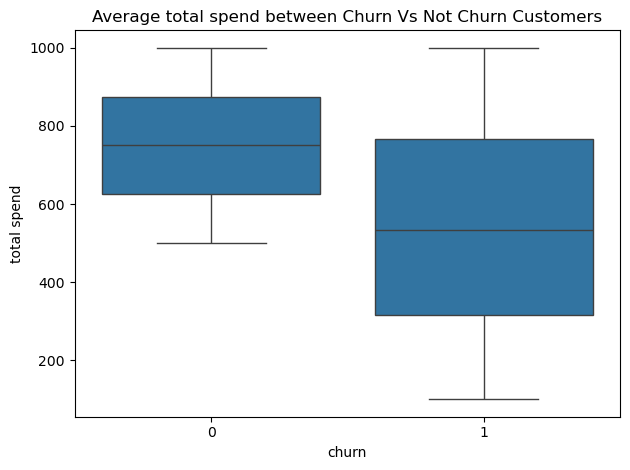

<Axes: xlabel='churn', ylabel='tenure'>

Text(0.5, 1.0, 'Average tenure between Churn Vs Not Churn Customers')

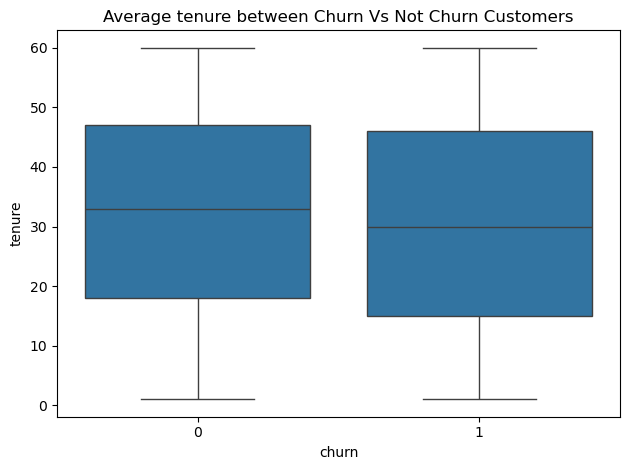

In [35]:
# [Subscription Type, Contract Length, Total Spend, Tenure] Vs Churn

compare_count = ["subscription type", "contract length"]
compare_box = ["total spend", "tenure"]

for col1 in compare_count:
    sns.countplot(x = col1, hue = "churn", data = df_train, palette = "coolwarm")
    plt.title(f"Customer Churn Distribution by {col1}")
    plt.tight_layout()
    plt.show()

for col2 in compare_box:
    sns.boxplot(x = "churn", y = col2, data = df_train)
    plt.title(f"Average {col2} between Churn Vs Not Churn Customers")
    plt.tight_layout()
    plt.show()

<Figure size 800x500 with 0 Axes>

Text(0.5, 0, 'Payment Delays(Days)')

Text(0, 0.5, 'Probability of Churn')

Text(0.5, 1.0, 'Probability of Churn by Payment Delay')

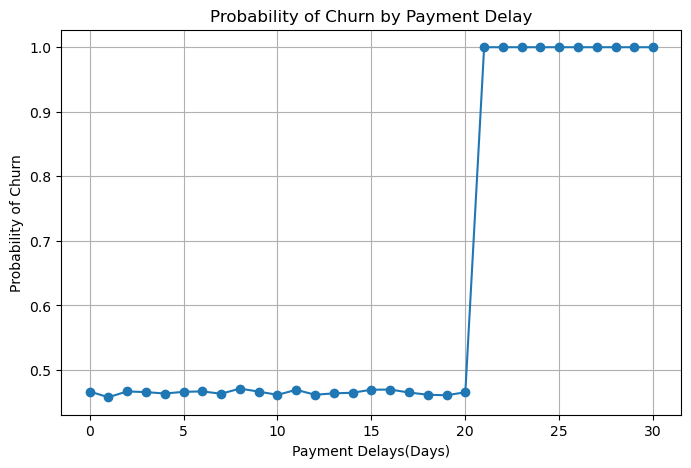

In [37]:
# Grouping by Payment Delay to calculate the Churn Probability
churn_prop = df_train.groupby("payment delay")["churn"].mean()

# Plot Churn Probability Vs Payment Delay
plt.figure(figsize = (8,5))
plt.plot(churn_prop.index, churn_prop.values, marker = "o", linestyle = "-")
plt.xlabel("Payment Delays(Days)")
plt.ylabel("Probability of Churn")
plt.title("Probability of Churn by Payment Delay")
plt.grid()
plt.show()

<Figure size 800x500 with 0 Axes>

Text(0.5, 0, 'Support Calls')

Text(0, 0.5, 'Probability of Churn')

Text(0.5, 1.0, 'Probability of Churn by Support Calls')

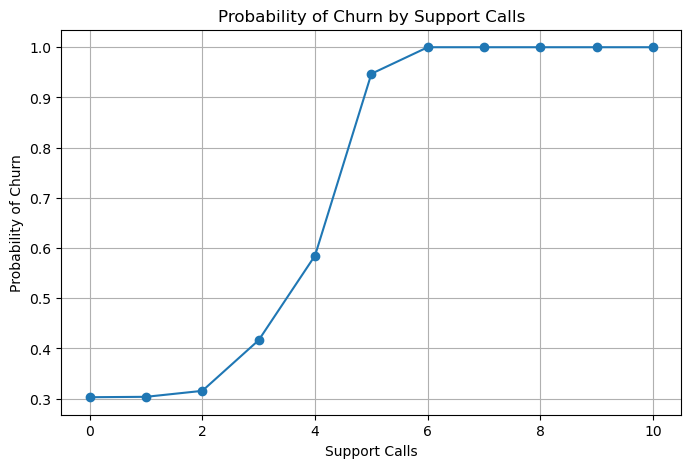

In [39]:
# Grouping by Support Calls to calculate churn propability
churn_prop_suppCalls = df_train.groupby("support calls")["churn"].mean()

# Plot Churn Probability Vs Support Calls
plt.figure(figsize = (8,5))
plt.plot(churn_prop_suppCalls.index, churn_prop_suppCalls.values, marker = "o", linestyle = "-")
plt.xlabel("Support Calls")
plt.ylabel("Probability of Churn")
plt.title("Probability of Churn by Support Calls")
plt.grid()
plt.show()

<Figure size 1000x600 with 0 Axes>

<Axes: >

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'age'),
  Text(1.5, 0, 'tenure'),
  Text(2.5, 0, 'usage frequency'),
  Text(3.5, 0, 'support calls'),
  Text(4.5, 0, 'payment delay'),
  Text(5.5, 0, 'total spend'),
  Text(6.5, 0, 'last interaction'),
  Text(7.5, 0, 'churn')])

Text(0.5, 1.0, 'Correlation Between Numeric Columns Vs Churn')

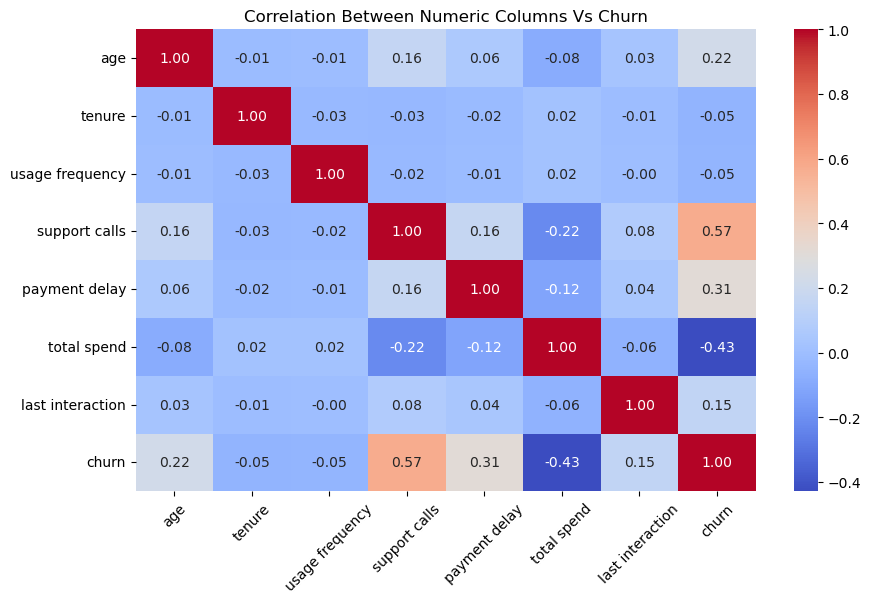

In [41]:
# Correlation between Numeric Columns
plt.figure(figsize = (10,6))
sns.heatmap(df_train.corr(numeric_only = True), annot = True, cmap = "coolwarm", fmt = ".2f")
plt.xticks(rotation = 45)
plt.title("Correlation Between Numeric Columns Vs Churn")
plt.show()

### **Age Group Segmentation**

In [43]:
print("Minimum Age: {}".format(df_train.age.min()))
print("Maximum Age: {}".format(df_train.age.max()))

Minimum Age: 18
Maximum Age: 65


<ul>
    <li>Young Adults: 18 - 24 years</li>
    <li>Young Professionals: 25 - 34 years</li>
    <li>Established Adults: 35 - 44 years</li>
    <li>Middle-Aged Consumers: 45 - 54 years</li>
    <li>Seniors: 55 - 65 years</li>
</ul>

In [45]:
def age_segmentation(age):
    if age < 18:
        return "Minors"
    elif 18 <= age <= 24:
        return "Young Adults"
    elif 25 <= age <= 34:
        return "Young Professionals"
    elif 35 <= age <= 44:
        return "Established Adults"
    elif 45 <= age <= 54:
        return "Middle-Aged Consumers"
    else:
        return "Seniors"


df_train["age group"] = df_train.age.apply(age_segmentation)
cols = list(df_train.columns)
df_train = df_train[cols[:-2] + [cols[-1], cols[-2]]]
df_train.head()

,age,gender,tenure,usage frequency,support calls,payment delay,subscription type,contract length,total spend,last interaction,age group,churn
customerid,,,,,,,,,,,,
2,30,Female,39,14,5,18,Standard,Annual,932.0,17,Young Professionals,1
3,65,Female,49,1,10,8,Basic,Monthly,557.0,6,Seniors,1
4,55,Female,14,4,6,18,Basic,Quarterly,185.0,3,Seniors,1
5,58,Male,38,21,7,7,Standard,Monthly,396.0,29,Seniors,1
6,23,Male,32,20,5,8,Basic,Monthly,617.0,20,Young Adults,1


<Axes: xlabel='age group', ylabel='count'>

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Young Professionals'),
  Text(1, 0, 'Seniors'),
  Text(2, 0, 'Young Adults'),
  Text(3, 0, 'Middle-Aged Consumers'),
  Text(4, 0, 'Established Adults')])

Text(0.5, 1.0, 'Customer Churn Distribution by Age Group')

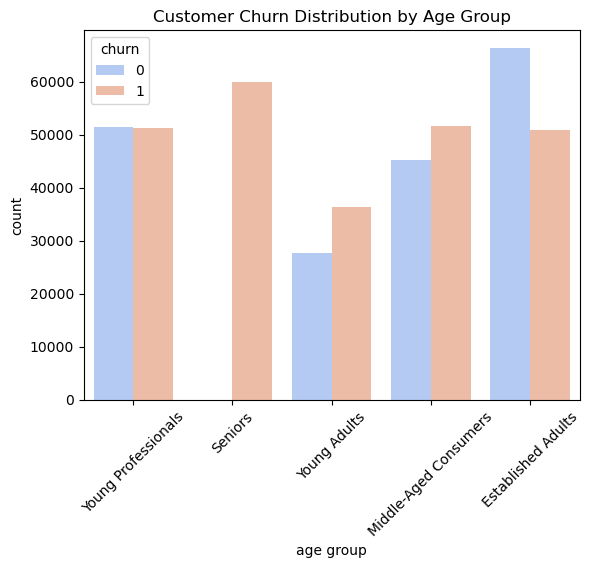

In [47]:
# Plot Customer Segmentation based on Age
sns.countplot(x = "age group", hue = "churn", data = df_train, palette = "coolwarm")
plt.xticks(rotation = 45)
plt.title("Customer Churn Distribution by Age Group")
plt.show()

<Axes: xlabel='gender', ylabel='count'>

([0, 1], [Text(0, 0, 'Female'), Text(1, 0, 'Male')])

Text(0.5, 1.0, 'Customer Churn Distribution by Gender')

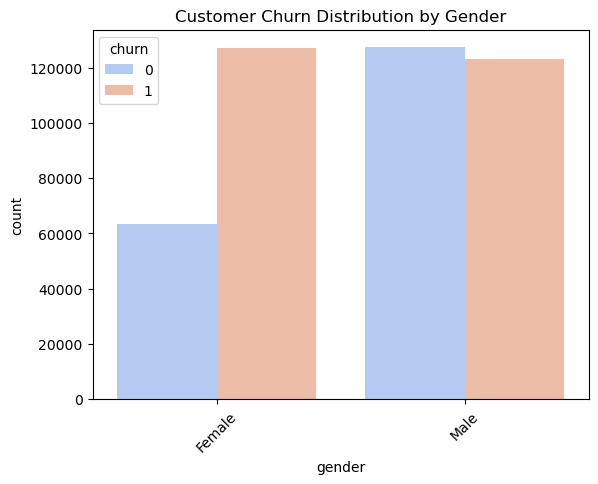

In [49]:
# Plot Customer Segmentation based on Gender
sns.countplot(x = "gender", hue = "churn", data = df_train, palette = "coolwarm")
plt.xticks(rotation = 45)
plt.title("Customer Churn Distribution by Gender")
plt.show()

## Data Preprocessing

**Splitting the Data**

In [51]:
# Storing the Train and Test set in separate Data Frames
train_df = df_train.copy().drop(columns = ["age group"])
test_df = df_test.copy()

# Modify the Column Names
test_df.columns = test_df.columns.str.lower()

# Setting the 'customerid column' as index
test_df = test_df.set_index("customerid")

In [53]:
# Pre-Processing Categorical Columns
categorical_features = ["gender", "subscription type", "contract length"]

train_df = pd.get_dummies(train_df, columns = categorical_features, drop_first = True)
test_df = pd.get_dummies(test_df, columns = categorical_features, drop_first = True)

# Separate Features and Target Variables
# 1. Training Set
X_train = train_df.drop(columns = ["churn"])
y_train = train_df["churn"]

# 2. Test Set
X_test = test_df.drop(columns = ["churn"])
y_test = test_df["churn"]

**Handle Class Imbalance using SMOTE.**

In [55]:
smote = SMOTE(random_state = 42)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Compute Sample Weights for Class Imbalance
sample_weights = compute_sample_weight(
                                        class_weight = "balanced",
                                        y = y_train_balanced)

<Figure size 1200x600 with 0 Axes>

<Axes: >

([<matplotlib.patches.Wedge at 0x146b9b8c0>,
 [Text(-1.075644810680109, -0.23019174888981714, '1'),
  Text(1.075644810680109, 0.230191748889817, '0')],
 [Text(-0.5867153512800594, -0.12555913575808206, '56.7%'),
  Text(0.5867153512800594, 0.125559135758082, '43.3%')])

Text(0.5, 1.0, 'Original Class Distribution')

<Axes: >

([<matplotlib.patches.Wedge at 0x137e84d10>,
 [Text(-1.1, 1.3471114790620887e-16, '1'),
  Text(1.1, -2.6942229581241775e-16, '0')],
 [Text(-0.6, 7.347880794884119e-17, '50.0%'),
  Text(0.6, -1.4695761589768238e-16, '50.0%')])

Text(0.5, 1.0, 'Balanced Class Distribution')

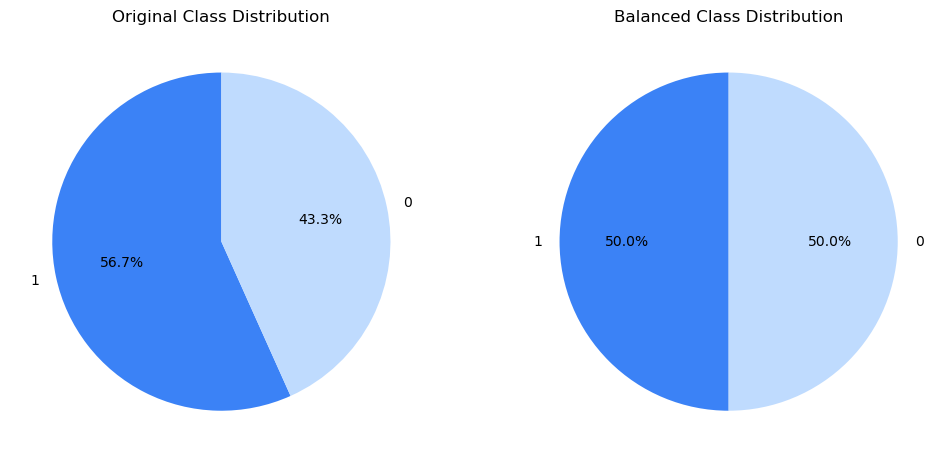

In [57]:
# Before SMOTE (Original Class Distribution)
original_class = Counter(y_train)

# After SMOTE (Balanced Class Distribution)
balanced_class = Counter(y_train_balanced)

# Plot the Original Class Distribution
plt.figure(figsize = (12,6))

# Subplot for Original Class Distribution
plt.subplot(1, 2, 1)
plt.pie(original_class.values(), labels = original_class.keys(), autopct = '%1.1f%%', startangle = 90, colors = ['#3B82F6', '#BFDBFE'])
plt.title("Original Class Distribution")

# Subplot for Balanced Class Distribution
plt.subplot(1, 2, 2)
plt.pie(balanced_class.values(), labels = balanced_class.keys(), autopct = '%1.1f%%', startangle = 90, colors = ['#3B82F6', '#BFDBFE'])
plt.title("Balanced Class Distribution")

# Show the Plot
plt.show()

**Normalizing the Data for ***Logistic Regression*** and ***MLP*** Models**

In [59]:
# Method to Scale
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

## Model Development & Model Evaluation

<ul>
    <li>Logistic Regression</li>
    <li>Decision Tree</li>
    <li>Gradient Boosting</li>
    <li>Multi Layer Perceptron (MLP)</li>
</ul>

### **Logistic Regression**

#### **Baseline Model**

(a) Initializing the Model

In [61]:
# Initialize Baseline Logistic Regression Model
logreg_baseM = LogisticRegression()

# Fit the Model
logreg_baseM.fit(X_train_scaled, y_train_balanced)

LogisticRegression()

(b) Evaluating the Model

**Precision:**
<ul>
    <li>Out of all the predicted positives, how many are actually positive</li>
    <li>Precision = TP / (TP + FP)</li>
    <li>High Precision means few False Positives</li>
</ul>

**Recall:**
<ul>
    <li>Out of all actual positives, how many did the model correctly identify</li>
    <li>Recall = TP / (TP + FN)</li>
    <li>High Recall means few False Negatives</li>
</ul>

**F1 Score**
<ul>
    <li>Harmonic mean of precision and recall. Balances both.</li>
    <li>F1-Score = 2 * [(Precision * Recall) / (Precision + Recall)]</li>
    <li>Used when you want a balance between precision and recall</li>
</ul>

**Confusion Matrix**
<ul>
    <li>True Positive (TP): Model correctly predicted positive class</li>
    <li>True Negative (TN): Model correctly predicted negative class</li>
    <li>False Positive (FP): Model incorrectly predicted the negative class as postive (Type 1 Error)</li>
    <li>False Negative (FN): Model incorrectly predicted the positive class as negative (Type 2 Error)</li>
</ul>

In [63]:
# Logistic Regression - Model Evaluation on Training Set

# Prediction on Training Set
logreg_baseM_y_train_pred = logreg_baseM.predict(X_train_scaled)

# Accuracy on Training Set
logreg_baseM_train_acc = accuracy_score(y_train_balanced, logreg_baseM_y_train_pred)

# Classification Report of Training Set
logreg_baseM_train_CR = classification_report(y_train_balanced, logreg_baseM_y_train_pred)

# Print the Result of Training Set
print("Logistic Regression Baseline Model Result on Training Data")
print(" ")
print("Logistic Regression Baseline Model Accuracy (Training Set): {}".format(logreg_baseM_train_acc))
print(" ")
print("Logistic Regression Baseline Model Classification Report (Training Set): \n", logreg_baseM_train_CR)

Logistic Regression Baseline Model Result on Training Data
 
Logistic Regression Baseline Model Accuracy (Training Set): 0.9048616194464778
 
Logistic Regression Baseline Model Classification Report (Training Set): 
               precision    recall  f1-score   support

           0       0.88      0.93      0.91    249999
           1       0.93      0.88      0.90    249999

    accuracy                           0.90    499998
   macro avg       0.91      0.90      0.90    499998
weighted avg       0.91      0.90      0.90    499998



In [65]:
# Logistics Regression - Model Evaluation on Test Set

# Prediction on Test Set
logreg_baseM_y_test_pred = logreg_baseM.predict(X_test_scaled)

# Accuracy on Test Set
logreg_baseM_test_acc = accuracy_score(y_test, logreg_baseM_y_test_pred)

# Classification Report of Test Set
logreg_baseM_test_CR = classification_report(y_test, logreg_baseM_y_test_pred)

# Print the Result of Test Set
print("Logistic Regression Baseline Model Result on Test Data")
print(" ")
print("Logistic Regression Baseline Model Accuracy (Test Set): {}".format(logreg_baseM_test_acc))
print(" ")
print("Logistic Regression Baseline Model Classification Report (Test Set): \n", " ", logreg_baseM_test_CR)

Logistic Regression Baseline Model Result on Test Data
 
Logistic Regression Baseline Model Accuracy (Test Set): 0.5762730294839532
 
Logistic Regression Baseline Model Classification Report (Test Set): 
                 precision    recall  f1-score   support

           0       0.95      0.21      0.34     33881
           1       0.53      0.99      0.69     30493

    accuracy                           0.58     64374
   macro avg       0.74      0.60      0.51     64374
weighted avg       0.75      0.58      0.50     64374



(c) ROC - AUC Curve

<Figure size 1000x800 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC-AUC Curve for Logistic Regression Baseline Model')

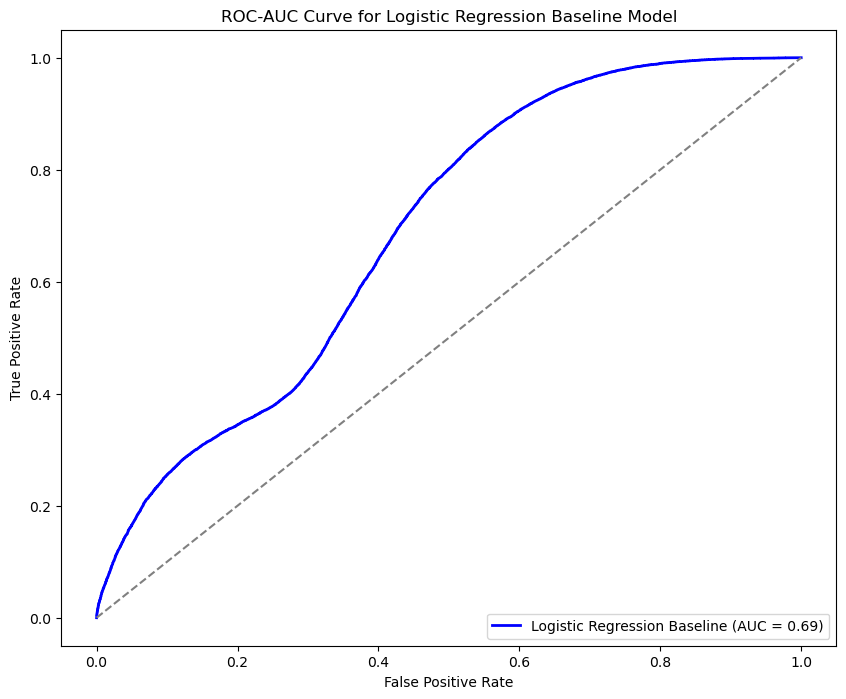

In [67]:
logreg_baseM_y_prob = logreg_baseM.predict_proba(X_test_scaled)[:,1]

logreg_baseM_fpr, logreg_baseM_tpr, _ = roc_curve(y_test, logreg_baseM_y_prob)

logreg_baseM_auc = auc(logreg_baseM_fpr, logreg_baseM_tpr)

# Plot the ROC - AUC Curve of Logistic Regression
plt.figure(figsize = (10,8))
plt.plot(logreg_baseM_fpr, logreg_baseM_tpr, label = f"Logistic Regression Baseline (AUC = {logreg_baseM_auc:.2f})", color = "blue", lw = 2)
plt.plot([0,1], [0,1], color = "gray", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Logistic Regression Baseline Model")
plt.legend(loc = "lower right")
plt.show()

(d) Confusion Matrix

In [69]:
# Confusion Matrix for Test Set of Logistic Regression
logreg_baseM_test_CM = confusion_matrix(y_test, logreg_baseM_y_test_pred)

# Print the Extracted Values
logreg_baseM_TN, logreg_baseM_FP, logreg_baseM_FN, logreg_baseM_TP = logreg_baseM_test_CM.ravel()

print("Confusion Matrix for Logistic Regression Baseline Model")
print(" ")
print("True Positives (TP): {}".format(logreg_baseM_TP))
print(" ")
print("False Positives (FP): {}".format(logreg_baseM_FP))
print(" ")
print("True Negatives (TN): {}".format(logreg_baseM_TN))
print(" ")
print("False Negatives (FN): {}".format(logreg_baseM_FN))

Confusion Matrix for Logistic Regression Baseline Model
 
True Positives (TP): 30143
 
False Positives (FP): 26927
 
True Negatives (TN): 6954
 
False Negatives (FN): 350


<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 14.722222222222216, 'Predicted Label')

Text(33.222222222222214, 0.5, 'Actual Label')

Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression Baseline Model')

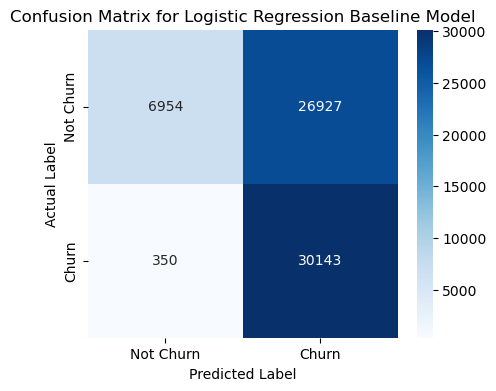

In [71]:
# Plot the Confusion Matrix for Test Set of Logistic Regression
plt.figure(figsize = (5,4))
sns.heatmap(logreg_baseM_test_CM, annot = True, fmt = 'd', cmap = "Blues",
            xticklabels = ["Not Churn", "Churn"], yticklabels = ["Not Churn", "Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Logistic Regression Baseline Model")
plt.show()

#### **Tuning the Model**

**Experiment 1**
<ul>
    <li>Regularization (Penalty): ['l1', 'l2']</li>
    <li>Regularization Strength (C): [0.001, 0.01, 0.1, 1]</li>
    <li>Solver: ['saga', 'lbfgs']</li>
</ul>

(a) Initializing the Model

In [73]:
# Initialize Logistic Regression Model with Experiment 1
logreg_E1 = LogisticRegression(max_iter = 1000)

# Define the hyperparameter 1
logreg_E1_param = {
                    'penalty' : ['l1', 'l2'],
                    'C' : [0.001, 0.01, 0.1, 1],
                    'solver' : ['saga', 'lbfgs']
                  }

# Grid Search Cross Validation
logreg_E1_grid = GridSearchCV(logreg_E1, param_grid = logreg_E1_param, cv = 5, scoring = "accuracy", n_jobs = -1, return_train_score = True)

# Fit the Logistic Regression Model
logreg_E1_grid.fit(X_train_scaled, y_train_balanced)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2'],
                         'solver': ['saga', 'lbfgs']},
             return_train_score=True, scoring='accuracy')

(b) Best Parameter and Best Model

In [75]:
# Best Parameter of Logistic Regression Model (Experiment 1)
logreg_E1_best_param = logreg_E1_grid.best_params_
print("Best Parameter of Logistic Regression Model (Experiment 1): {}".format(logreg_E1_best_param))

# Best Model of Logistic Regression Model (Experiment 1)
logreg_E1_best_model = logreg_E1_grid.best_estimator_

Best Parameter of Logistic Regression Model (Experiment 1): {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}


(c) Evaluating the Model

In [77]:
# Logistic Regression (Experiment 1) - Model Evaluation on Training Set

# Prediction on Training Set
logreg_E1_y_train_pred = logreg_E1_best_model.predict(X_train_scaled)

# Accuracy on Training Set
logreg_E1_train_acc = accuracy_score(y_train_balanced, logreg_E1_y_train_pred)

# Classification Report of Training Set
logreg_E1_train_CR = classification_report(y_train_balanced, logreg_E1_y_train_pred)

# Print the Result of Training Set
print("Logistic Regression (Experiment 1) Result on Training Data")
print(" ")
print("Logistic Regression (Experiment 1) Accuracy (Training Set): {}".format(logreg_E1_train_acc))
print(" ")
print("Logistic Regression (Experiment 1) Classification Report (Training Set):\n", logreg_E1_train_CR)

Logistic Regression (Experiment 1) Result on Training Data
 
Logistic Regression (Experiment 1) Accuracy (Training Set): 0.9052176208704835
 
Logistic Regression (Experiment 1) Classification Report (Training Set):
               precision    recall  f1-score   support

           0       0.88      0.93      0.91    249999
           1       0.93      0.88      0.90    249999

    accuracy                           0.91    499998
   macro avg       0.91      0.91      0.91    499998
weighted avg       0.91      0.91      0.91    499998



In [79]:
# Logistic Regression (Experiment 1) - Model Evaluation on Test Set

# Prediction on Test Set
logreg_E1_y_test_pred = logreg_E1_best_model.predict(X_test_scaled)

# Accuracy on Test Set
logreg_E1_test_acc = accuracy_score(y_test, logreg_E1_y_test_pred)

# Classification Report of Test Set
logreg_E1_test_CR = classification_report(y_test, logreg_E1_y_test_pred)

# Print the Result of Test Set
print("Logistic Regression (Experiment 1) Result on Test Data")
print(" ")
print("Logistic Regression (Experiment 1) Accuracy (Test Set): {}".format(logreg_E1_test_acc))
print(" ")
print("Logistic Regression (Experiment 1) Classification Report (Test Set):\n", logreg_E1_test_CR)

Logistic Regression (Experiment 1) Result on Test Data
 
Logistic Regression (Experiment 1) Accuracy (Test Set): 0.5778730543387082
 
Logistic Regression (Experiment 1) Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.95      0.21      0.34     33881
           1       0.53      0.99      0.69     30493

    accuracy                           0.58     64374
   macro avg       0.74      0.60      0.52     64374
weighted avg       0.75      0.58      0.51     64374



(d) ROC - AUC Curve

<Figure size 1000x800 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC-AUC Curve for Logistic Regression (Experiment 1) Model')

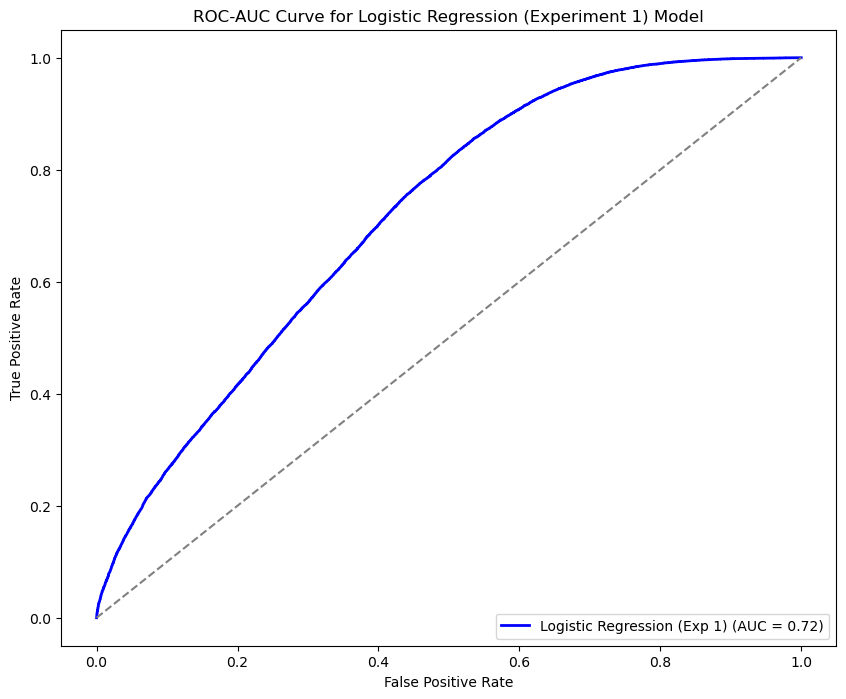

In [81]:
logreg_E1_y_prob = logreg_E1_best_model.predict_proba(X_test_scaled)[:,1]

logreg_E1_fpr, logreg_E1_tpr, _ = roc_curve(y_test, logreg_E1_y_prob)

logreg_E1_auc = auc(logreg_E1_fpr, logreg_E1_tpr)

# Plot the ROC - AUC Curve of Logistic Regression
plt.figure(figsize = (10,8))
plt.plot(logreg_E1_fpr, logreg_E1_tpr, label = f"Logistic Regression (Exp 1) (AUC = {logreg_E1_auc:.2f})", color = "blue", lw = 2)
plt.plot([0,1], [0,1], color = "gray", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Logistic Regression (Experiment 1) Model")
plt.legend(loc = "lower right")
plt.show()

(e) Confusion Matrix

In [83]:
# Confusion Matrix for Test Set of Logistic Regression (Experiment 1)
logreg_E1_test_CM = confusion_matrix(y_test, logreg_E1_y_test_pred)

# Print the Extracted Values
logreg_E1_TN, logreg_E1_FP, logreg_E1_FN, logreg_E1_TP = logreg_E1_test_CM.ravel()

print("Confusion Matrix for Logistic Regression (Experiment 1)")
print(" ")
print("True Positives (TP): {}".format(logreg_E1_TP))
print(" ")
print("False Positives (FP): {}".format(logreg_E1_FP))
print(" ")
print("True Negatives (TN): {}".format(logreg_E1_TN))
print(" ")
print("False Negatives (FN): {}".format(logreg_E1_FN))

Confusion Matrix for Logistic Regression (Experiment 1)
 
True Positives (TP): 30140
 
False Positives (FP): 26821
 
True Negatives (TN): 7060
 
False Negatives (FN): 353


<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 14.722222222222216, 'Predicted Label')

Text(33.222222222222214, 0.5, 'Actual Label')

Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression (Experiment 1)')

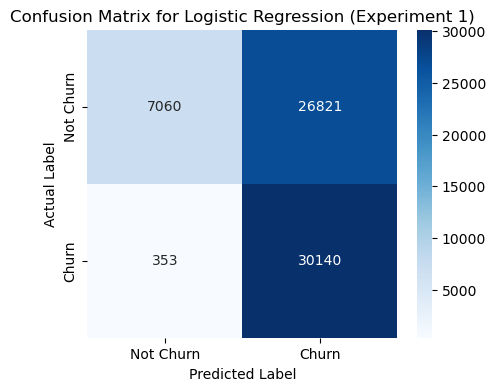

In [85]:
# Plot the Confusion Matrix for Test Set of Logistic Regression (Experiment 1)
plt.figure(figsize = (5,4))
sns.heatmap(logreg_E1_test_CM, annot = True, fmt = 'd', cmap = "Blues",
            xticklabels = ["Not Churn", "Churn"], yticklabels = ["Not Churn", "Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Logistic Regression (Experiment 1)")
plt.show()

**Experiment 2**
<ul>
    <li>Regularization (Penalty): ['l1', 'l2']</li>
    <li><font color = "blue">Regularization Strength (C): [0.000001,0.00001,0.0001,0.001]</font></li>
    <li>Solver: ['saga', 'lbfgs']</li>
</ul>

(a) Initializing the Model

In [87]:
# Initialize Logistic Regression Model with Experiment 2
logreg_E2 = LogisticRegression(max_iter = 1000)

# Define the hyperparameter 2
logreg_E2_param = {
                    'penalty' : ['l1', 'l2'],
                    'C' : [0.000001,0.00001,0.0001,0.001],
                    'solver' : ['saga', 'lbfgs']
                  }

# Grid Search Cross Validation
logreg_E2_grid = GridSearchCV(logreg_E2, param_grid = logreg_E2_param, cv = 5, scoring = "accuracy", n_jobs = -1, return_train_score = True)

# Fit the Logistic Regression Model
logreg_E2_grid.fit(X_train_scaled, y_train_balanced)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001],
                         'penalty': ['l1', 'l2'], 'solver': ['saga', 'lbfgs']},
             return_train_score=True, scoring='accuracy')

(b) Best Parameter and Best Model

In [89]:
# Best Parameter of Logistic Regression Model (Experiment 2)
logreg_E2_best_param = logreg_E2_grid.best_params_
print("Best Parameter of Logistic Regression Model (Experiment 2): {}".format(logreg_E2_best_param))

# Best Model of Logistic Regression Model (Experiment 2)
logreg_E2_best_model = logreg_E2_grid.best_estimator_

Best Parameter of Logistic Regression Model (Experiment 2): {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}


In [91]:
if logreg_E1_best_param == logreg_E2_best_param:
    print("Same Result")
else:
    print("Different Result")

Same Result


#### **Conclusions**

Even after reducing the regularization strength (C value), the model continued to select the same parameters as in Experiment 1. Furthermore, tuning the logistic regression model did not lead to any significant improvement in performance metrics. Therefore, the next logical step is to explore more advanced models, such as **Decision Trees**.

### **Decision Tree**

#### **Baseline Model**

(a) Initializing the Model

In [93]:
# Initialize Baseline Decision Tree Model
dectree_baseM = DecisionTreeClassifier()

# Fit the Model
dectree_baseM.fit(X_train_balanced, y_train_balanced)

DecisionTreeClassifier()

(b) Evaluating the Model

In [95]:
# Decision Tree - Model Evaluation on Training Set

# Prediction on Training Set
dectree_baseM_y_train_pred = dectree_baseM.predict(X_train_balanced)

# Accuracy of Training Set
dectree_baseM_train_acc = accuracy_score(y_train_balanced, dectree_baseM_y_train_pred)

# Classification Report of Training Set
dectree_baseM_train_CR = classification_report(y_train_balanced, dectree_baseM_y_train_pred)

# Print the Result of Training Set
print("Decision Tree Baseline Model Result on Training Data")
print(" ")
print("Decision Tree Baseline Model Accuracy (Training Set): {}".format(dectree_baseM_train_acc))
print(" ")
print("Decision Tree Baseline Model Classification Report (Training Set): \n", dectree_baseM_train_CR)

Decision Tree Baseline Model Result on Training Data
 
Decision Tree Baseline Model Accuracy (Training Set): 1.0
 
Decision Tree Baseline Model Classification Report (Training Set): 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    249999
           1       1.00      1.00      1.00    249999

    accuracy                           1.00    499998
   macro avg       1.00      1.00      1.00    499998
weighted avg       1.00      1.00      1.00    499998



In [97]:
# Decision Tree - Model Evaluation on Test Set

# Prediction on Test Set
dectree_baseM_y_test_pred = dectree_baseM.predict(X_test)

# Accuracy of Test Set
dectree_baseM_test_acc = accuracy_score(y_test, dectree_baseM_y_test_pred)

# Classification Report of Test Set
dectree_baseM_test_CR = classification_report(y_test, dectree_baseM_y_test_pred)

# Print the Result of Test Set
print("Decision Tree Baseline Model Result on Test Data")
print(" ")
print("Decision Tree Baseline Model Accuracy (Test Set): {}".format(dectree_baseM_test_acc))
print(" ")
print("Decision Tree Baseline Model Classification Report (Test Set): \n", dectree_baseM_test_CR)

Decision Tree Baseline Model Result on Test Data
 
Decision Tree Baseline Model Accuracy (Test Set): 0.5034330630378724
 
Decision Tree Baseline Model Classification Report (Test Set): 
               precision    recall  f1-score   support

           0       0.98      0.06      0.11     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.50     64374
   macro avg       0.73      0.53      0.38     64374
weighted avg       0.75      0.50      0.37     64374



(c) ROC - AUC Curve

<Figure size 1000x800 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC-AUC Curve for Decision Tree Baseline Model')

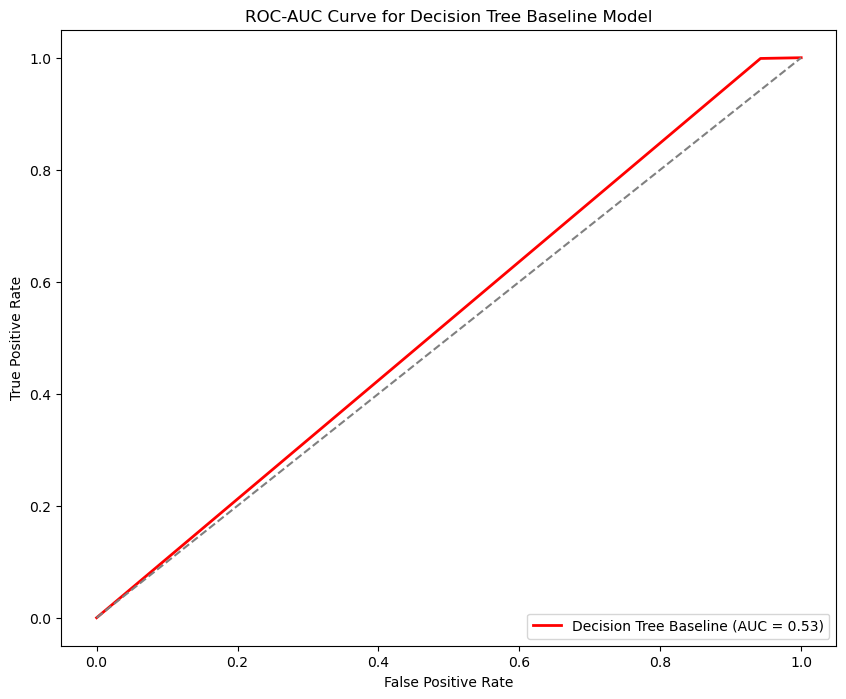

In [99]:
dectree_baseM_y_prob = dectree_baseM.predict_proba(X_test)[:,1]

dectree_baseM_fpr, dectree_baseM_tpr, _ = roc_curve(y_test, dectree_baseM_y_prob)

dectree_baseM_auc = auc(dectree_baseM_fpr, dectree_baseM_tpr)

# Plot the ROC - AUC Curve of Decision Tree
plt.figure(figsize = (10,8))
plt.plot(dectree_baseM_fpr, dectree_baseM_tpr, label = f"Decision Tree Baseline (AUC = {dectree_baseM_auc:.2f})", color = "red", lw = 2)
plt.plot([0,1], [0,1], color = "gray", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Decision Tree Baseline Model")
plt.legend(loc = "lower right")
plt.show()

(d) Confusion Matrix

In [101]:
# Confusion Matrix for Test Set of Decision Tree
dectree_baseM_test_CM = confusion_matrix(y_test, dectree_baseM_y_test_pred)

# Print the Extracted Values
dectree_baseM_TN, dectree_baseM_FP, dectree_baseM_FN, dectree_baseM_TP = dectree_baseM_test_CM.ravel()

print("Confusion Matrix for Decision Tree Baseline Model")
print(" ")
print("True Positives (TP): {}".format(dectree_baseM_TP))
print(" ")
print("False Positives (FP): {}".format(dectree_baseM_FP))
print(" ")
print("True Negatives (TN): {}".format(dectree_baseM_TN))
print(" ")
print("False Negatives (FN): {}".format(dectree_baseM_FN))

Confusion Matrix for Decision Tree Baseline Model
 
True Positives (TP): 30453
 
False Positives (FP): 31926
 
True Negatives (TN): 1955
 
False Negatives (FN): 40


<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 14.722222222222216, 'Predicted Label')

Text(33.222222222222214, 0.5, 'Actual Label')

Text(0.5, 1.0, 'Confusion Matrix for Decision Tree Baseline Model')

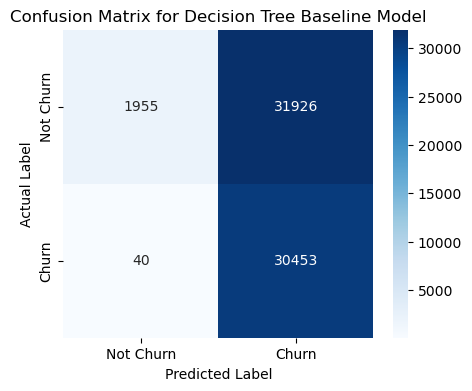

In [103]:
# Plot the Confusion Matrix for Test Set of Decision Tree
plt.figure(figsize = (5,4))
sns.heatmap(dectree_baseM_test_CM, annot = True, fmt = 'd', cmap = "Blues",
            xticklabels = ["Not Churn", "Churn"], yticklabels = ["Not Churn", "Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Decision Tree Baseline Model")
plt.show()

#### **Tuning the Model**

**Experiment 1**
<ul>
    <li>max_depth: 3, 5, 7</li>
    <li>min_samples_split: 30, 40, 50</li>
    <li>min_samples_leaf: 40, 50, 60</li>
    <li>ccp_alpha: 0.08, 0.2, 10</li>
</ul>

(a) Initializing the Model

In [105]:
# Initialize Decision Tree Model (Experiment 1)
dectree_E1 = DecisionTreeClassifier(random_state = 0)

# Define the hyperparameter 1
dectree_E1_param = {
                    'max_depth' : [3,5,7],
                    'min_samples_split' : [30, 40, 50],
                    'min_samples_leaf' : [40, 50, 60],
                    'ccp_alpha' : np.linspace(0.08, 0.2, 10)
                    }

# Grid Search Cross Validation
dectree_E1_grid = GridSearchCV(dectree_E1, param_grid = dectree_E1_param, cv = 5, scoring = "accuracy", return_train_score = True)

# Fit the Model
dectree_E1_grid.fit(X_train_balanced, y_train_balanced)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'ccp_alpha': array([0.08      , 0.09333333, 0.10666667, 0.12      , 0.13333333,
       0.14666667, 0.16      , 0.17333333, 0.18666667, 0.2       ]),
                         'max_depth': [3, 5, 7],
                         'min_samples_leaf': [40, 50, 60],
                         'min_samples_split': [30, 40, 50]},
             return_train_score=True, scoring='accuracy')

(b) Best Parameter and Best Model

In [107]:
# Best Parameter of Decision Tree Model (Experiment 1)
dectree_E1_best_param = dectree_E1_grid.best_params_
print("Best Parameter of Decision Tree Model (Experiment 1): {}".format(dectree_E1_best_param))

# Best Model of Decision Tree Model (Experiment 1)
dectree_E1_best_model = dectree_E1_grid.best_estimator_

Best Parameter of Decision Tree Model (Experiment 1): {'ccp_alpha': 0.08, 'max_depth': 3, 'min_samples_leaf': 40, 'min_samples_split': 30}


(c) Evaluating the Model

In [109]:
# Decision Tree (Experiment 1) - Model Evaluation on Training Set

# Prediction on Training Set
dectree_E1_y_train_pred = dectree_E1_best_model.predict(X_train_balanced)

# Accuracy of Training Set
dectree_E1_train_acc = accuracy_score(y_train_balanced, dectree_E1_y_train_pred)

# Classification Report of Training Set
dectree_E1_train_CR = classification_report(y_train_balanced, dectree_E1_y_train_pred)

# Print the Result of Training Set
print("Decision Tree Model (Experiment 1) Result on Training Data")
print(" ")
print("Decision Tree Model (Experiment 1) Accuracy (Training Set): {}".format(dectree_E1_train_acc))
print(" ")
print("Decision Tree Model (Experiment 1) Classification Report (Training Set): \n", dectree_E1_train_CR)

Decision Tree Model (Experiment 1) Result on Training Data
 
Decision Tree Model (Experiment 1) Accuracy (Training Set): 0.8871395485581942
 
Decision Tree Model (Experiment 1) Classification Report (Training Set): 
               precision    recall  f1-score   support

           0       0.82      0.99      0.90    249999
           1       0.99      0.78      0.87    249999

    accuracy                           0.89    499998
   macro avg       0.91      0.89      0.89    499998
weighted avg       0.91      0.89      0.89    499998



In [111]:
# Decision Tree (Experiment 1) - Model Evaluation on Test Set

# Prediction on Test Set
dectree_E1_y_test_pred = dectree_E1_best_model.predict(X_test)

# Accuracy of Test Set
dectree_E1_test_acc = accuracy_score(y_test, dectree_E1_y_test_pred)

# Classification Report of Test Set
dectree_E1_test_CR = classification_report(y_test, dectree_E1_y_test_pred)

# Print the Result of Test Set
print("Decision Tree Model (Experiment 1) Result on Test Data")
print(" ")
print("Decision Tree Model (Experiment 1) Accuracy (Test Set): {}".format(dectree_E1_test_acc))
print(" ")
print("Decision Tree Model (Experiment 1) Classification Report (Test Set): \n", dectree_E1_test_CR)

Decision Tree Model (Experiment 1) Result on Test Data
 
Decision Tree Model (Experiment 1) Accuracy (Test Set): 0.6081492528039271
 
Decision Tree Model (Experiment 1) Classification Report (Test Set): 
               precision    recall  f1-score   support

           0       0.84      0.32      0.46     33881
           1       0.55      0.93      0.69     30493

    accuracy                           0.61     64374
   macro avg       0.70      0.62      0.58     64374
weighted avg       0.70      0.61      0.57     64374



(c) ROC - AUC Curve

<Figure size 1000x800 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC-AUC Curve for Decision Tree (Experiment 1) Model')

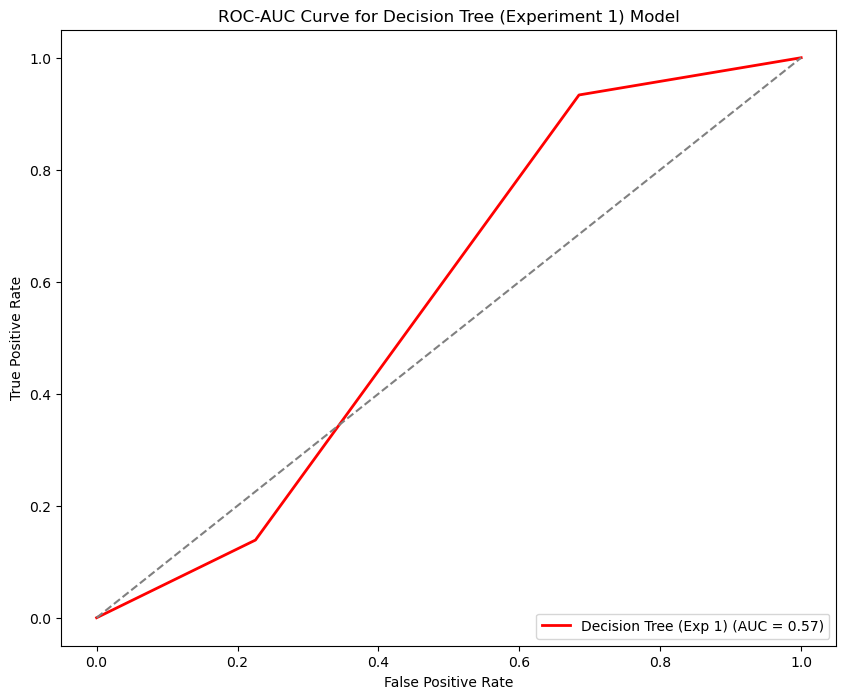

In [113]:
dectree_E1_y_prob = dectree_E1_best_model.predict_proba(X_test)[:,1]

dectree_E1_fpr, dectree_E1_tpr, _ = roc_curve(y_test, dectree_E1_y_prob)

dectree_E1_auc = auc(dectree_E1_fpr, dectree_E1_tpr)

# Plot the ROC - AUC Curve of Decision Tree (Experiment 1)
plt.figure(figsize = (10,8))
plt.plot(dectree_E1_fpr, dectree_E1_tpr, label = f"Decision Tree (Exp 1) (AUC = {dectree_E1_auc:.2f})", color = "red", lw = 2)
plt.plot([0,1], [0,1], color = "gray", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Decision Tree (Experiment 1) Model")
plt.legend(loc = "lower right")
plt.show()

(d) Confusion Matrix

In [115]:
# Confusion Matrix for Test Set of Decision Tree (Experiment 1)
dectree_E1_test_CM = confusion_matrix(y_test, dectree_E1_y_test_pred)

# Print the Extracted Values
dectree_E1_TN, dectree_E1_FP, dectree_E1_FN, dectree_E1_TP = dectree_E1_test_CM.ravel()

print("Confusion Matrix for Decision Tree (Experiment 1) Model")
print(" ")
print("True Positives (TP): {}".format(dectree_E1_TP))
print(" ")
print("False Positives (FP): {}".format(dectree_E1_FP))
print(" ")
print("True Negatives (TN): {}".format(dectree_E1_TN))
print(" ")
print("False Negatives (FN): {}".format(dectree_E1_FN))

Confusion Matrix for Decision Tree (Experiment 1) Model
 
True Positives (TP): 28465
 
False Positives (FP): 23197
 
True Negatives (TN): 10684
 
False Negatives (FN): 2028


<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 14.722222222222216, 'Predicted Label')

Text(33.222222222222214, 0.5, 'Actual Label')

Text(0.5, 1.0, 'Confusion Matrix for Decision Tree (Experiment 1) Model')

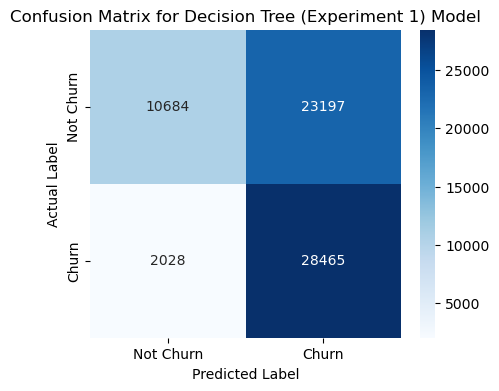

In [117]:
# Plot the Confusion Matrix for Test Set of Decision Tree (Experiment 1)
plt.figure(figsize = (5,4))
sns.heatmap(dectree_E1_test_CM, annot = True, fmt = "d", cmap = "Blues",
            xticklabels = ["Not Churn", "Churn"], yticklabels = ["Not Churn", "Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Decision Tree (Experiment 1) Model")
plt.show()

**Experiment 2**
<ul>
    <li><font color = "blue">max_depth: 2, 3, 4, 5</font></li>
    <li><font color = "blue">min_samples_split: 50, 60, 80</font></li>
    <li><font color = "blue">min_samples_leaf: 50, 60, 100</font></li>
    <li><font color = "blue">ccp_alpha: 0.1, 0.5, 1.0</font></li>
    <li><font color = "blue">class_weight: balanced</font></li>
</ul>

(a) Initializing the Model

In [119]:
# Initialize Decision Tree Model (Experiment 2)
dectree_E2 = DecisionTreeClassifier(random_state = 0)

# Define the hyperparameter 2
dectree_E2_param = {
                    'max_depth' : [2, 3, 4, 5],
                    'min_samples_split' : [50, 60, 80],
                    'min_samples_leaf' : [50, 60, 100],
                    'ccp_alpha' : np.linspace(0.1, 0.5, 1),
                    'class_weight' : ['balanced']
                    }

# Grid Search Cross Validation
dectree_E2_grid = GridSearchCV(dectree_E2, param_grid = dectree_E2_param, cv = 5, scoring = "accuracy", return_train_score = True)

# Fit the Model
dectree_E2_grid.fit(X_train_balanced, y_train_balanced)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'ccp_alpha': array([0.1]),
                         'class_weight': ['balanced'],
                         'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [50, 60, 100],
                         'min_samples_split': [50, 60, 80]},
             return_train_score=True, scoring='accuracy')

(b) Best Parameter and Best Model

In [121]:
# Best Parameter of Decision Tree Model (Experiment 2)
dectree_E2_best_param = dectree_E2_grid.best_params_
print("Best Parameter of Decision Tree Model (Experiment 2): {}".format(dectree_E2_best_param))

# Best Model of Decision Tree Model (Experiment 2)
dectree_E2_best_model = dectree_E2_grid.best_estimator_

Best Parameter of Decision Tree Model (Experiment 2): {'ccp_alpha': 0.1, 'class_weight': 'balanced', 'max_depth': 2, 'min_samples_leaf': 50, 'min_samples_split': 50}


(c) Evaluating the Model

In [123]:
# Decision Tree (Experiment 2) - Model Evaluation on Training Set

# Prediction on Training Set
dectree_E2_y_train_pred = dectree_E2_best_model.predict(X_train_balanced)

# Accuracy of Training Set
dectree_E2_train_acc = accuracy_score(y_train_balanced, dectree_E2_y_train_pred)

# Classification Report of Training Set
dectree_E2_train_CR = classification_report(y_train_balanced, dectree_E2_y_train_pred)

# Print the Result of Training Set
print("Decision Tree Model (Experiment 2) Result on Training Data")
print(" ")
print("Decision Tree Model (Experiment 2) Accuracy (Training Set): {}".format(dectree_E2_train_acc))
print(" ")
print("Decision Tree Model (Experiment 2) Classification Report (Training Set): \n", dectree_E2_train_CR)

Decision Tree Model (Experiment 2) Result on Training Data
 
Decision Tree Model (Experiment 2) Accuracy (Training Set): 0.8871395485581942
 
Decision Tree Model (Experiment 2) Classification Report (Training Set): 
               precision    recall  f1-score   support

           0       0.82      0.99      0.90    249999
           1       0.99      0.78      0.87    249999

    accuracy                           0.89    499998
   macro avg       0.91      0.89      0.89    499998
weighted avg       0.91      0.89      0.89    499998



In [125]:
# Decision Tree (Experiment 2) - Model Evaluation on Test Set

# Prediction on Test Set
dectree_E2_y_test_pred = dectree_E2_best_model.predict(X_test)

# Accuracy of Test Set
dectree_E2_test_acc = accuracy_score(y_test, dectree_E2_y_test_pred)

# Classification Report of Test Set
dectree_E2_test_CR = classification_report(y_test, dectree_E2_y_test_pred)

# Print the Result of Test Set
print("Decision Tree Model (Experiment 2) Result on Test Data")
print(" ")
print("Decision Tree Model (Experiment 2) Accuracy (Test Set): {}".format(dectree_E2_test_acc))
print(" ")
print("Decision Tree Model (Experiment 2) Classification Report (Test Set): \n", dectree_E2_test_CR)

Decision Tree Model (Experiment 2) Result on Test Data
 
Decision Tree Model (Experiment 2) Accuracy (Test Set): 0.6081492528039271
 
Decision Tree Model (Experiment 2) Classification Report (Test Set): 
               precision    recall  f1-score   support

           0       0.84      0.32      0.46     33881
           1       0.55      0.93      0.69     30493

    accuracy                           0.61     64374
   macro avg       0.70      0.62      0.58     64374
weighted avg       0.70      0.61      0.57     64374



(d) ROC - AUC Curve

<Figure size 1000x800 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC-AUC Curve for Decision Tree (Experiment 2) Model')

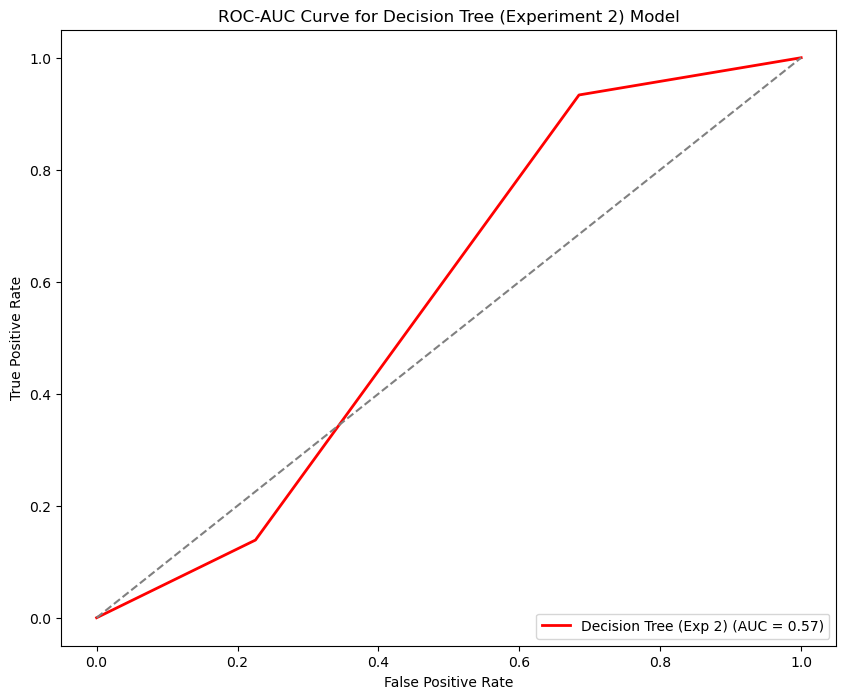

In [127]:
dectree_E2_y_prob = dectree_E2_best_model.predict_proba(X_test)[:,1]

dectree_E2_fpr, dectree_E2_tpr, _ = roc_curve(y_test, dectree_E2_y_prob)

dectree_E2_auc = auc(dectree_E2_fpr, dectree_E2_tpr)

# Plot the ROC - AUC Curve of Decision Tree (Experiment 2)
plt.figure(figsize = (10,8))
plt.plot(dectree_E2_fpr, dectree_E2_tpr, label = f"Decision Tree (Exp 2) (AUC = {dectree_E2_auc:.2f})", color = "red", lw = 2)
plt.plot([0,1], [0,1], color = "gray", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Decision Tree (Experiment 2) Model")
plt.legend(loc = "lower right")
plt.show()

(e) Confusion Matrix

In [129]:
# Confusion Matrix for Test Set of Decision Tree (Experiment 2)
dectree_E2_test_CM = confusion_matrix(y_test, dectree_E2_y_test_pred)

# Print the Extracted Values
dectree_E2_TN, dectree_E2_FP, dectree_E2_FN, dectree_E2_TP = dectree_E2_test_CM.ravel()

print("Confusion Matrix for Decision Tree (Experiment 2) Model")
print(" ")
print("True Positives (TP): {}".format(dectree_E2_TP))
print(" ")
print("False Positives (FP): {}".format(dectree_E2_FP))
print(" ")
print("True Negatives (TN): {}".format(dectree_E2_TN))
print(" ")
print("False Negatives (FN): {}".format(dectree_E2_FN))

Confusion Matrix for Decision Tree (Experiment 2) Model
 
True Positives (TP): 28465
 
False Positives (FP): 23197
 
True Negatives (TN): 10684
 
False Negatives (FN): 2028


<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 14.722222222222216, 'Predicted Label')

Text(33.222222222222214, 0.5, 'Actual Label')

Text(0.5, 1.0, 'Confusion Matrix for Decision Tree (Experiment 2) Model')

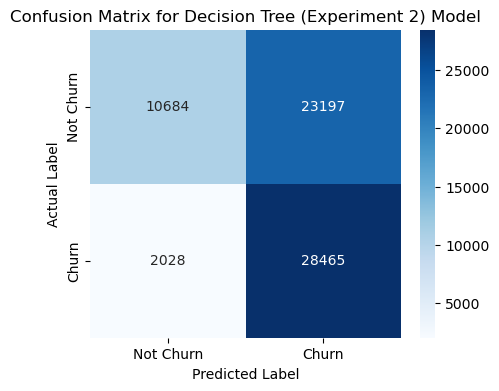

In [131]:
# Plot the Confusion Matrix for Test Set of Decision Tree (Experiment 2)
plt.figure(figsize = (5,4))
sns.heatmap(dectree_E2_test_CM, annot = True, fmt = "d", cmap = "Blues",
            xticklabels = ["Not Churn", "Churn"], yticklabels = ["Not Churn", "Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Decision Tree (Experiment 2) Model")
plt.show()

**Conclusion**

The Decision Tree model performs well on the training set but struggles to generalize to the test data. The high recall and low precision suggest that the model overpredicts positive cases, leading to a high false positive rate. Despite hyperparameter tuning and pruning, the overfitting issue persists, as evidenced by the drop in accuracy and F1-score on the test set.

### **Gradient Boosting**

#### **Baseline Model**

(a) Initializing the Model

In [133]:
# Initialize the Baseline Gradient Boosting Model
gboost_baseM = GradientBoostingClassifier(random_state = 0)

# Fit the model
gboost_baseM.fit(X_train_balanced, y_train_balanced)

GradientBoostingClassifier(random_state=0)

(b) Evaluating the Model

In [135]:
# Gradient Boosting - Model Evaluation on Training Set

# Prediction on Training Data
gboost_baseM_y_train_pred = gboost_baseM.predict(X_train_balanced)

# Accuracy of Training Set
gboost_baseM_train_acc = accuracy_score(y_train_balanced, gboost_baseM_y_train_pred)

# Classification Report of Training Set
gboost_baseM_train_CR = classification_report(y_train_balanced, gboost_baseM_y_train_pred)

# Print the Result of Training Set
print("Gradient Boosting Baseline Model Result on Training Data")
print(" ")
print("Gradient Boosting Baseline Model Accuracy (Training Set): {}".format(gboost_baseM_train_acc))
print(" ")
print("Gradient Boosting Baseline Model Classification Report (Training Set): \n", gboost_baseM_train_CR)

Gradient Boosting Baseline Model Result on Training Data
 
Gradient Boosting Baseline Model Accuracy (Training Set): 0.9973859895439582
 
Gradient Boosting Baseline Model Classification Report (Training Set): 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    249999
           1       1.00      0.99      1.00    249999

    accuracy                           1.00    499998
   macro avg       1.00      1.00      1.00    499998
weighted avg       1.00      1.00      1.00    499998



In [137]:
# Gradient Boosting - Model Evaluation on Test Set

# Prediction on Test Data
gboost_baseM_y_test_pred = gboost_baseM.predict(X_test)

# Accuracy of Test Set
gboost_baseM_test_acc = accuracy_score(y_test, gboost_baseM_y_test_pred)

# Classification Report of Test Set
gboost_baseM_test_CR = classification_report(y_test, gboost_baseM_y_test_pred)

# Print the Result of Test Set
print("Gradient Boosting Baseline Model Result on Test Data")
print(" ")
print("Gradient Boosting Baseline Model Accuracy (Test Set): {}".format(gboost_baseM_test_acc))
print(" ")
print("Gradient Boosting Baseline Model Classification Report (Test Set): \n", gboost_baseM_test_CR)

Gradient Boosting Baseline Model Result on Test Data
 
Gradient Boosting Baseline Model Accuracy (Test Set): 0.5058874700966228
 
Gradient Boosting Baseline Model Classification Report (Test Set): 
               precision    recall  f1-score   support

           0       0.98      0.06      0.12     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.51     64374
   macro avg       0.73      0.53      0.39     64374
weighted avg       0.75      0.51      0.37     64374



(c) ROC - AUC Curve

<Figure size 1000x800 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC-AUC Curve of Gradient Boosting Basline Model')

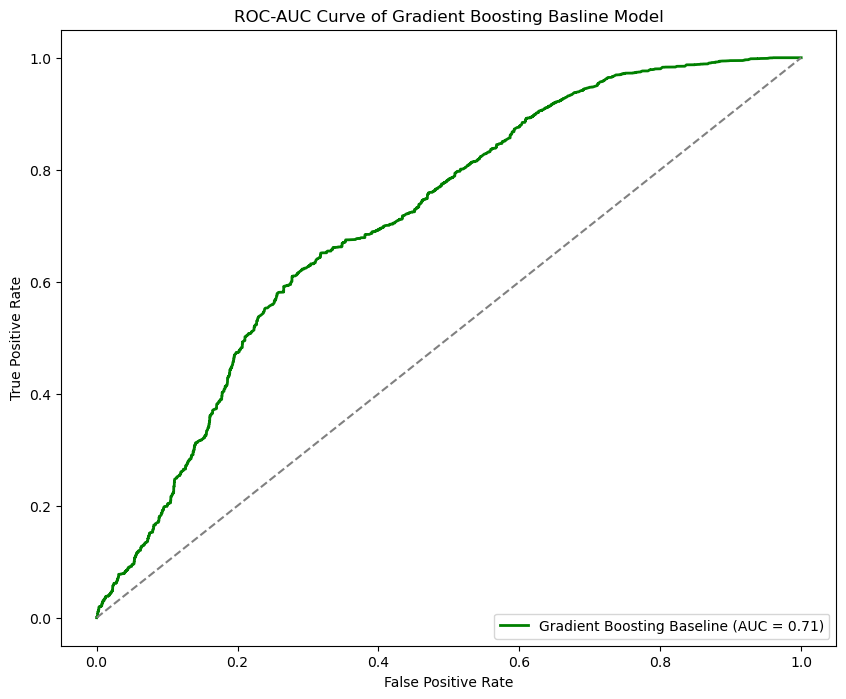

In [139]:
gboost_baseM_y_prob = gboost_baseM.predict_proba(X_test)[:,1]

gboost_baseM_fpr, gboost_baseM_tpr, _ = roc_curve(y_test, gboost_baseM_y_prob)

gboost_baseM_auc = auc(gboost_baseM_fpr, gboost_baseM_tpr)

# Plot the ROC - AUC Curve of Gradient Boosting
plt.figure(figsize = (10,8))
plt.plot(gboost_baseM_fpr, gboost_baseM_tpr, label = f"Gradient Boosting Baseline (AUC = {gboost_baseM_auc:.2f})", color = "green", lw = 2)
plt.plot([0,1], [0,1], color = "gray", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve of Gradient Boosting Basline Model")
plt.legend(loc = "lower right")
plt.show()

(d) Confusion Matrix

In [141]:
# Confusion Matrix for Test Set of Gradient Boosting
gboost_baseM_test_CM = confusion_matrix(y_test, gboost_baseM_y_test_pred)

# Print the Extracted Values
gboost_baseM_TN, gboost_baseM_FP, gboost_baseM_FN, gboost_baseM_TP = gboost_baseM_test_CM.ravel()

print("Confusion Matrix of Gradient Boosting Baseline Model")
print(" ")
print("True Positives (TP): {}".format(gboost_baseM_TP))
print(" ")
print("False Positives (FP): {}".format(gboost_baseM_FP))
print(" ")
print("True Negatives (TN): {}".format(gboost_baseM_TN))
print(" ")
print("False Negatives (FN): {}".format(gboost_baseM_FN))

Confusion Matrix of Gradient Boosting Baseline Model
 
True Positives (TP): 30442
 
False Positives (FP): 31757
 
True Negatives (TN): 2124
 
False Negatives (FN): 51


<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 14.722222222222216, 'Predicted Label')

Text(33.222222222222214, 0.5, 'Actual Label')

Text(0.5, 1.0, 'Confusion Matrix of Gradient Boosting Basline Model')

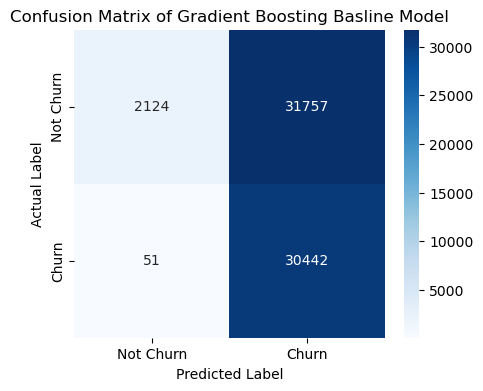

In [143]:
# Plot the Confusion Matrix for Test Set of Gradient Boosting
plt.figure(figsize = (5,4))
sns.heatmap(gboost_baseM_test_CM, annot = True, fmt = "d", cmap = "Blues",
            xticklabels = ["Not Churn", "Churn"], yticklabels = ["Not Churn", "Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix of Gradient Boosting Basline Model")
plt.show()

#### **Tuning the Model**

**Experiment 1**
<ul>
    <li>n_estimator: 10, 15, 25</li>
    <li>learning_rate: 0.002, 0.005, 0.01, 0.1</li>
    <li>max_depth: 1</li>
    <li>subsample: 0.6, 0.7</li>
    <li>min_samples_split: 50, 100</li>
</ul>

(a) Initializing the Model

In [145]:
# Initialize Gradient Boosting Model (Experiment 1)
gboost_E1 = GradientBoostingClassifier(random_state = 0)

# Define the hyperparameter 1
gboost_E1_param = {
                    'n_estimators' : [10, 15, 25],
                    'learning_rate' : [0.002, 0.005, 0.01, 0.1],
                    'max_depth' : [1],
                    'subsample' : [0.6, 0.7],
                    'min_samples_split' : [50, 100]
                    }

# Grid Search Cross Validation
gboost_E1_grid = GridSearchCV(gboost_E1, param_grid = gboost_E1_param, cv = 5, scoring = "accuracy",
                              n_jobs = -1, verbose = 2, return_train_score = True)

# Fit the Model
gboost_E1_grid.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.002, 0.005, 0.01, 0.1],
                         'max_depth': [1], 'min_samples_split': [50, 100],
                         'n_estimators': [10, 15, 25],
                         'subsample': [0.6, 0.7]},
             return_train_score=True, scoring='accuracy', verbose=2)

(b) Best Parameter and Best Model

In [147]:
# Best Parameter of Gradient Boosting Model (Experiment 1)
gboost_E1_best_param = gboost_E1_grid.best_params_
print("Best Parameter of Gradient Boosting Model (Experiment 1): {}".format(gboost_E1_best_param))

# Best Model of Gradient Boosting Model (Experiment 1)
gboost_E1_best_model = gboost_E1_grid.best_estimator_

Best Parameter of Gradient Boosting Model (Experiment 1): {'learning_rate': 0.1, 'max_depth': 1, 'min_samples_split': 50, 'n_estimators': 25, 'subsample': 0.6}


(c) Evaluating the Model

In [149]:
# Gradient Boosting - Model Evaluation on Training Set

# Prediction on Training Data
gboost_E1_y_train_pred = gboost_E1_best_model.predict(X_train_balanced)

# Accuracy of Training Set
gboost_E1_train_acc = accuracy_score(y_train_balanced, gboost_E1_y_train_pred)

# Classification Report of Training Set
gboost_E1_train_CR = classification_report(y_train_balanced, gboost_E1_y_train_pred)

# Print the Result of Training Set
print("Gradient Boosting Model (Experiment 1) Result on Training Data")
print(" ")
print("Gradient Boosting Model (Experiment 1) Accuracy (Training Set): {}".format(gboost_E1_train_acc))
print(" ")
print("Gradient Boosting Model (Experiment 1) Classification Report (Training Set): \n", gboost_E1_train_CR)

Gradient Boosting Model (Experiment 1) Result on Training Data
 
Gradient Boosting Model (Experiment 1) Accuracy (Training Set): 0.9315897263589055
 
Gradient Boosting Model (Experiment 1) Classification Report (Training Set): 
               precision    recall  f1-score   support

           0       0.88      0.99      0.94    249999
           1       0.99      0.87      0.93    249999

    accuracy                           0.93    499998
   macro avg       0.94      0.93      0.93    499998
weighted avg       0.94      0.93      0.93    499998



In [151]:
# Gradient Boosting - Model Evaluation on Test Set

# Prediction on Test Data
gboost_E1_y_test_pred = gboost_E1_best_model.predict(X_test)

# Accuracy of Test Set
gboost_E1_test_acc = accuracy_score(y_test, gboost_E1_y_test_pred)

# Classification Report of Test Set
gboost_E1_test_CR = classification_report(y_test, gboost_E1_y_test_pred)

# Print the Result of Test Set
print("Gradient Boosting Model (Experiment 1) Result on Test Data")
print(" ")
print("Gradient Boosting Model (Experiment 1) Accuracy (Test Set): {}".format(gboost_E1_test_acc))
print(" ")
print("Gradient Boosting Model (Experiment 1) Classification Report (Test Set): \n", gboost_E1_test_CR)

Gradient Boosting Model (Experiment 1) Result on Test Data
 
Gradient Boosting Model (Experiment 1) Accuracy (Test Set): 0.5893217758722465
 
Gradient Boosting Model (Experiment 1) Classification Report (Test Set): 
               precision    recall  f1-score   support

           0       0.98      0.22      0.36     33881
           1       0.54      1.00      0.70     30493

    accuracy                           0.59     64374
   macro avg       0.76      0.61      0.53     64374
weighted avg       0.77      0.59      0.52     64374



(d) ROC - AUC Curve

<Figure size 1000x800 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC-AUC Curve of Gradient Boosting (Experiment 1) Model')

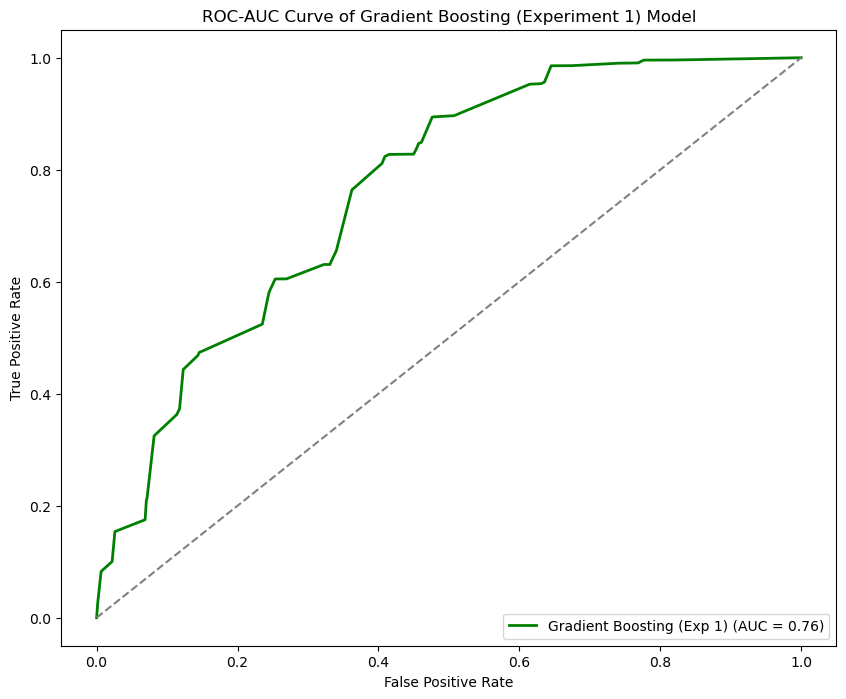

In [153]:
gboost_E1_y_prob = gboost_E1_best_model.predict_proba(X_test)[:,1]

gboost_E1_fpr, gboost_E1_tpr, _ = roc_curve(y_test, gboost_E1_y_prob)

gboost_E1_auc = auc(gboost_E1_fpr, gboost_E1_tpr)

# Plot the ROC - AUC Curve of Gradient Boosting (Experiment 1)
plt.figure(figsize = (10,8))
plt.plot(gboost_E1_fpr, gboost_E1_tpr, label = f"Gradient Boosting (Exp 1) (AUC = {gboost_E1_auc:.2f})", color = "green", lw = 2)
plt.plot([0,1], [0,1], color = "gray", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve of Gradient Boosting (Experiment 1) Model")
plt.legend(loc = "lower right")
plt.show()

(e) Confusion Matrix

In [155]:
# Confusion Matrix for Test Set of Gradient Boosting (Experiment 1)
gboost_E1_test_CM = confusion_matrix(y_test, gboost_E1_y_test_pred)

# Print the Extracted Values
gboost_E1_TN, gboost_E1_FP, gboost_E1_FN, gboost_E1_TP = gboost_E1_test_CM.ravel()

print("Confusion Matrix of Gradient Boosting (Experiment 1) Model")
print(" ")
print("True Positives (TP): {}".format(gboost_E1_TP))
print(" ")
print("False Positives (FP): {}".format(gboost_E1_FP))
print(" ")
print("True Negatives (TN): {}".format(gboost_E1_TN))
print(" ")
print("False Negatives (FN): {}".format(gboost_E1_FN))

Confusion Matrix of Gradient Boosting (Experiment 1) Model
 
True Positives (TP): 30362
 
False Positives (FP): 26306
 
True Negatives (TN): 7575
 
False Negatives (FN): 131


<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 14.722222222222216, 'Predicted Label')

Text(33.222222222222214, 0.5, 'Actual Label')

Text(0.5, 1.0, 'Confusion Matrix of Gradient Boosting (Experiment 1) Model')

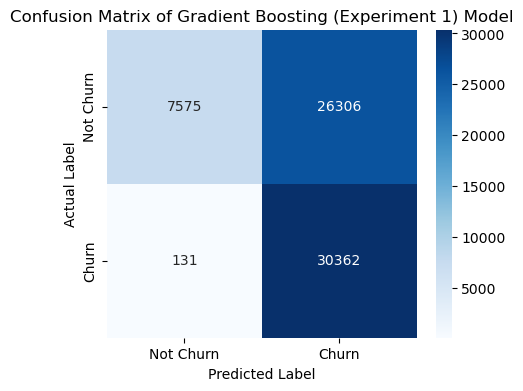

In [157]:
# Plot the Confusion Matrix for Test Set of Gradient Boosting (Experiment 1)
plt.figure(figsize = (5,4))
sns.heatmap(gboost_E1_test_CM, annot = True, fmt = "d", cmap = "Blues",
            xticklabels = ["Not Churn", "Churn"], yticklabels = ["Not Churn", "Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix of Gradient Boosting (Experiment 1) Model")
plt.show()

**Experiment 2**
<ul>
    <li>n_estimators : 10, 15, 25</li>
    <li><font color = "blue">learning_rate : 0.002, 0.005</font></li>
    <li>max_depth : 1</li>
    <li>subsample : 0.6, 0.7</li>
    <li>min_samples_split : 50, 100</li>
</ul>

(a) Initializing the Model

In [166]:
# Initialize Gradient Boosting Model (Experiment 2)
gboost_E2 = GradientBoostingClassifier(random_state = 0)

# Define the hyperparameter 2
gboost_E2_param = {
                    "n_estimators" : [10, 15, 25],
                    "learning_rate" : [0.002, 0.005],
                    "max_depth" : [1],
                    "subsample" : [0.6, 0.7],
                    "min_samples_split" : [50, 100]
                  }

# Grid Search Cross Validation
gboost_E2_grid = GridSearchCV(gboost_E2, param_grid = gboost_E2_param, cv = 5, scoring = "accuracy",
                              n_jobs = -1, verbose = 2, return_train_score = True)

# Fit the Model
gboost_E2_grid.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.002, 0.005], 'max_depth': [1],
                         'min_samples_split': [50, 100],
                         'n_estimators': [10, 15, 25],
                         'subsample': [0.6, 0.7]},
             return_train_score=True, scoring='accuracy', verbose=2)

(b) Best Parameter and Best Model

In [168]:
# Best Parameter of Gradient Boosting Model (Experiment 2)
gboost_E2_best_param = gboost_E2_grid.best_params_
print("Best Parameter of Gradient Boosting Model (Experiment 2): {}".format(gboost_E2_best_param))

# Best Model of Gradient Boosting Model (Experiment 2)
gboost_E2_best_model = gboost_E2_grid.best_estimator_

Best Parameter of Gradient Boosting Model (Experiment 2): {'learning_rate': 0.002, 'max_depth': 1, 'min_samples_split': 50, 'n_estimators': 10, 'subsample': 0.6}


(c) Evaluating the Model

In [170]:
# Gradient Boosting (Experiment 2) - Model Evaluation on Training Set

# Prediction on Training Data
gboost_E2_y_train_pred = gboost_E2_best_model.predict(X_train_balanced)

# Accuracy of Training Set
gboost_E2_train_acc = accuracy_score(y_train_balanced, gboost_E2_y_train_pred)

# Classification Report of Training Set
gboost_E2_train_CR = classification_report(y_train_balanced, gboost_E2_y_train_pred)

# Print the Result of Training Set
print("Gradient Boosting Model (Experiment 2) Result on Training Data")
print(" ")
print("Gradient Boosting Model (Experiment 2) Accuracy (Training Set): {}".format(gboost_E2_train_acc))
print(" ")
print("Gradient Boosting Model (Experiment 2) Classification Report (Training Set): \n", gboost_E2_train_CR)

Gradient Boosting Model (Experiment 2) Result on Training Data
 
Gradient Boosting Model (Experiment 2) Accuracy (Training Set): 0.7815211260845043
 
Gradient Boosting Model (Experiment 2) Classification Report (Training Set): 
               precision    recall  f1-score   support

           0       0.70      0.99      0.82    249999
           1       0.99      0.57      0.72    249999

    accuracy                           0.78    499998
   macro avg       0.84      0.78      0.77    499998
weighted avg       0.84      0.78      0.77    499998



In [172]:
# Gradient Boosting (Experiment 2) - Model Evaluation on Test Set

# Prediction on Test Data
gboost_E2_y_test_pred = gboost_E2_best_model.predict(X_test)

# Accuracy of Test Set
gboost_E2_test_acc = accuracy_score(y_test, gboost_E2_y_test_pred)

# Classification Report of Test Set
gboost_E2_test_CR = classification_report(y_test, gboost_E2_y_test_pred)

# Print the Result of Test Set
print("Gradient Boosting Model (Experiment 2) Result on Test Data")
print(" ")
print("Gradient Boosting Model (Experiment 2) Accuracy (Test Set): {}".format(gboost_E2_test_acc))
print(" ")
print("Gradient Boosting Model (Experiment 2) Classification Report (Test Set): \n", gboost_E2_test_CR)

Gradient Boosting Model (Experiment 2) Result on Test Data
 
Gradient Boosting Model (Experiment 2) Accuracy (Test Set): 0.6611054152297512
 
Gradient Boosting Model (Experiment 2) Classification Report (Test Set): 
               precision    recall  f1-score   support

           0       0.75      0.54      0.63     33881
           1       0.61      0.79      0.69     30493

    accuracy                           0.66     64374
   macro avg       0.68      0.67      0.66     64374
weighted avg       0.68      0.66      0.66     64374



(d) ROC - AUC Curve

<Figure size 1000x800 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC-AUC Curve of Gradient Boosting (Experiment 2) Model')

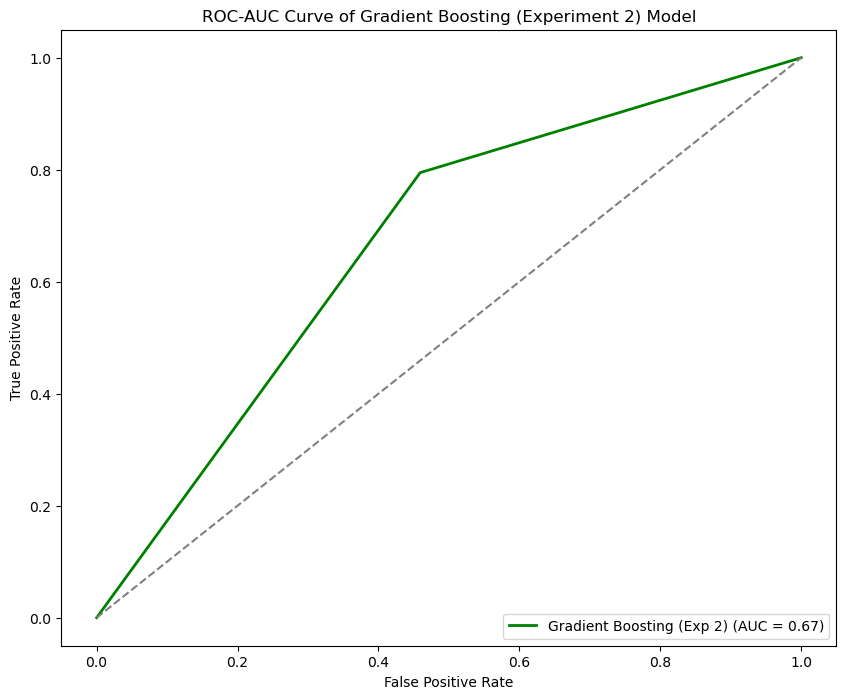

In [174]:
gboost_E2_y_prob = gboost_E2_best_model.predict_proba(X_test)[:,1]

gboost_E2_fpr, gboost_E2_tpr, _ = roc_curve(y_test, gboost_E2_y_prob)

gboost_E2_auc = auc(gboost_E2_fpr, gboost_E2_tpr)

# Plot the ROC - AUC Curve of Gradient Boosting (Experiment 2)
plt.figure(figsize = (10,8))
plt.plot(gboost_E2_fpr, gboost_E2_tpr, label = f"Gradient Boosting (Exp 2) (AUC = {gboost_E2_auc:.2f})", color = "green", lw = 2)
plt.plot([0,1], [0,1], color = "gray", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve of Gradient Boosting (Experiment 2) Model")
plt.legend(loc = "lower right")
plt.show()

(e) Confusion Matrix

In [178]:
# Confusion Matrix for Test Set of Gradient Boosting (Experiment 2)
gboost_E2_test_CM = confusion_matrix(y_test, gboost_E2_y_test_pred)

# Print the Extracted Values
gboost_E2_TN, gboost_E2_FP, gboost_E2_FN, gboost_E2_TP = gboost_E2_test_CM.ravel()

print("Confusion Matrix of Gradient Boosting (Experiment 2) Model")
print(" ")
print("True Positives (TP): {}".format(gboost_E2_TP))
print(" ")
print("False Positives (FP): {}".format(gboost_E2_FP))
print(" ")
print("True Negatives (TN): {}".format(gboost_E2_TN))
print(" ")
print("False Negatives (FN): {}".format(gboost_E2_FN))

Confusion Matrix of Gradient Boosting (Experiment 2) Model
 
True Positives (TP): 24236
 
False Positives (FP): 15559
 
True Negatives (TN): 18322
 
False Negatives (FN): 6257


<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 14.722222222222216, 'Predicted Label')

Text(33.222222222222214, 0.5, 'Actual Label')

Text(0.5, 1.0, 'Confusion Matrix of Gradient Boosting (Experiment 2) Model')

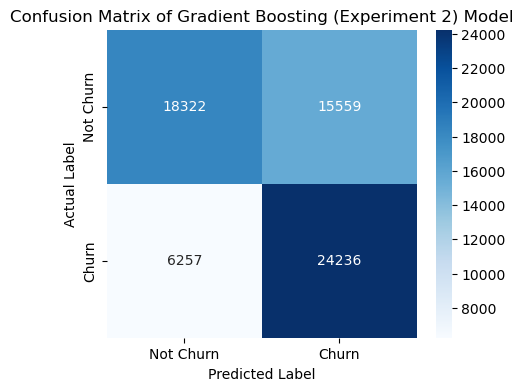

In [180]:
# Plot the Confusion Matrix for Test Set of Gradient Boosting (Experiment 2)
plt.figure(figsize = (5,4))
sns.heatmap(gboost_E2_test_CM, annot = True, fmt = "d", cmap = "Blues",
            xticklabels = ["Not Churn", "Churn"], yticklabels = ["Not Churn", "Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix of Gradient Boosting (Experiment 2) Model")
plt.show()

**Conclusions**

After deploying and tuning the Gradient Boosting model, it demonstrates comparatively better performance. Although the test accuracy remains slightly lower than the training accuracy, the model successfully reduces the gap between them, suggesting improved generalization. The precision and recall scores indicate that the model is able to distinguish between positive and negative classes more effectively than random guessing, though some misclassifications still occur. With a ROC-AUC score of 0.67, the model shows a moderate ability to separate the classes. Further improvements may be achieved by fine-tuning hyperparameters, such as subsampling rates, learning rate decay, or incorporating class weighting.

### **Multi Layer Perceptron (MLP) Model**

#### **Baseline Model**

(a) Initializing the Model

In [188]:
# Initialize the Baseline MLP Model
mlp_baseM = MLPClassifier(random_state = 42)

# Fit the model
mlp_baseM.fit(X_train_scaled, y_train_balanced)

MLPClassifier(random_state=42)

(b) Evaluating the Model

In [190]:
# MLP (Baseline) - Model Evaluation on Training Set

# Prediction on Training Data
mlp_baseM_y_train_pred = mlp_baseM.predict(X_train_scaled)

# Accuracy of Training Set
mlp_baseM_train_acc = accuracy_score(y_train_balanced, mlp_baseM_y_train_pred)

# Classification Report of Training Set
mlp_baseM_train_CR = classification_report(y_train_balanced, mlp_baseM_y_train_pred)

# Print the Result of Training Set
print("MLP Baseline Model Result on Training Data")
print(" ")
print("MLP Baseline Model Accuracy (Training Set): {}".format(mlp_baseM_train_acc))
print(" ")
print("MLP Baseline Model Classification Report (Training Set): \n", mlp_baseM_train_CR)

MLP Baseline Model Result on Training Data
 
MLP Baseline Model Accuracy (Training Set): 0.9990179960719843
 
MLP Baseline Model Classification Report (Training Set): 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    249999
           1       1.00      1.00      1.00    249999

    accuracy                           1.00    499998
   macro avg       1.00      1.00      1.00    499998
weighted avg       1.00      1.00      1.00    499998



In [192]:
# MLP (Baseline) - Model Evaluation on Test Set

# Prediction on Test Data
mlp_baseM_y_test_pred = mlp_baseM.predict(X_test_scaled)

# Accuracy of Test Set
mlp_baseM_test_acc = accuracy_score(y_test, mlp_baseM_y_test_pred)

# Classification Report of Test Set
mlp_baseM_test_CR = classification_report(y_test, mlp_baseM_y_test_pred)

# Print the Result of Test Set
print("MLP Baseline Model Result on Test Data")
print(" ")
print("MLP Baseline Model Accuracy (Test Set): {}".format(mlp_baseM_test_acc))
print(" ")
print("MLP Baseline Model Classification Report (Test Set): \n", mlp_baseM_test_CR)

MLP Baseline Model Result on Test Data
 
MLP Baseline Model Accuracy (Test Set): 0.5043029794637587
 
MLP Baseline Model Classification Report (Test Set): 
               precision    recall  f1-score   support

           0       0.98      0.06      0.11     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.50     64374
   macro avg       0.73      0.53      0.38     64374
weighted avg       0.75      0.50      0.37     64374



(c) ROC - AUC Curve

<Figure size 1000x800 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC-AUC Curve of MLP Baseline Model')

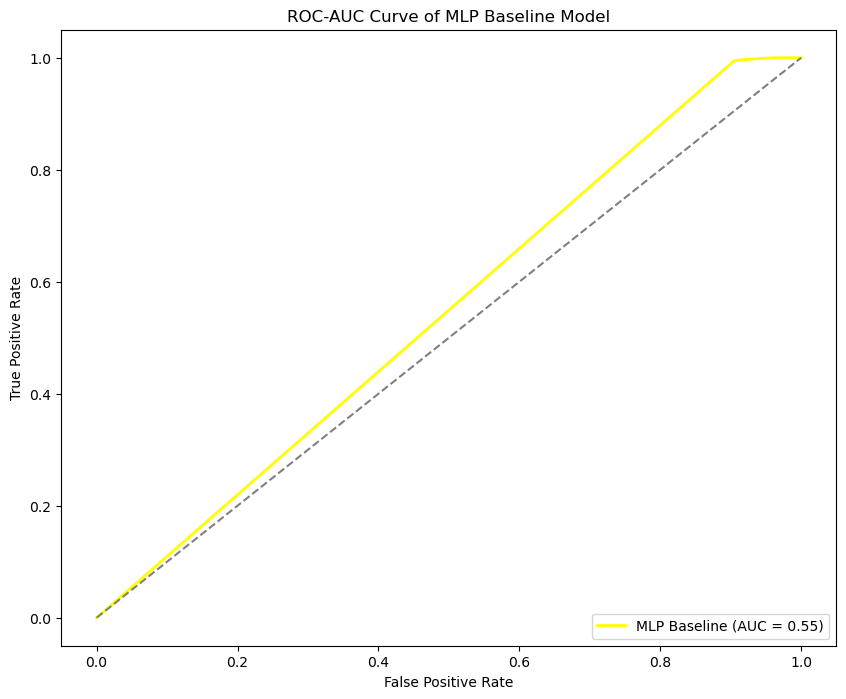

In [194]:
mlp_baseM_y_prob = mlp_baseM.predict_proba(X_test_scaled)[:,1]

mlp_baseM_fpr, mlp_baseM_tpr, _ = roc_curve(y_test, mlp_baseM_y_prob)

mlp_baseM_auc = auc(mlp_baseM_fpr, mlp_baseM_tpr)

# Plot the ROC - AUC Curve of MLP (Baseline)
plt.figure(figsize = (10,8))
plt.plot(mlp_baseM_fpr, mlp_baseM_tpr, label = f"MLP Baseline (AUC = {mlp_baseM_auc:.2f})", color = "yellow", lw = 2)
plt.plot([0,1], [0,1], color = "gray", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve of MLP Baseline Model")
plt.legend(loc = "lower right")
plt.show()

(d) Confusion Matrix

In [196]:
# Confusion Matrix for Test Set of MLP
mlp_baseM_test_CM = confusion_matrix(y_test, mlp_baseM_y_test_pred)

# Print the Extracted Values
mlp_baseM_TN, mlp_baseM_FP, mlp_baseM_FN, mlp_baseM_TP = mlp_baseM_test_CM.ravel()

print("Confusion Matrix of MLP Baseline Model")
print(" ")
print("True Positives (TP): {}".format(mlp_baseM_TP))
print(" ")
print("False Positives (FP): {}".format(mlp_baseM_FP))
print(" ")
print("True Negatives (TN): {}".format(mlp_baseM_TN))
print(" ")
print("False Negatives (FN): {}".format(mlp_baseM_FN))

Confusion Matrix of MLP Baseline Model
 
True Positives (TP): 30448
 
False Positives (FP): 31865
 
True Negatives (TN): 2016
 
False Negatives (FN): 45


<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 14.722222222222216, 'Predicted Label')

Text(33.222222222222214, 0.5, 'Actual Label')

Text(0.5, 1.0, 'Confusion Matrix of MLP Baseline Model')

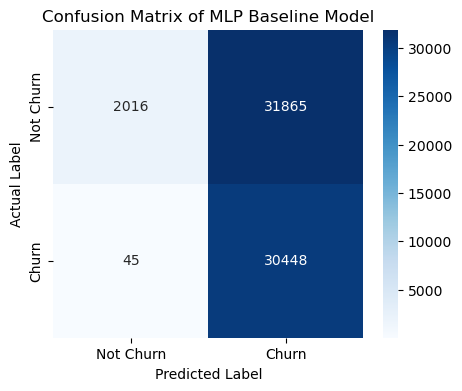

In [198]:
# Plot the Confusion Matrix for Test Set of MLP (Baseline)
plt.figure(figsize = (5,4))
sns.heatmap(mlp_baseM_test_CM, annot = True, fmt = "d", cmap = "Blues",
            xticklabels = ["Not Churn", "Churn"], yticklabels = ["Not Churn", "Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix of MLP Baseline Model")
plt.show()

#### **Tuning the Model**

**Experiment 1**
<ul>
    <li>hidden_layer_sizes : (32,), (64,)</li>
    <li>activation : relu</li>
    <li>solver : adam</li>
    <li>alpha : 100.0, 500.0, 1000.0</li>
    <li>max_iter : 500, 1000</li>
</ul>

(a) Initializing the Model

In [222]:
# Initialize MLP Model (Experiment 1)
mlp_E1 = MLPClassifier(random_state = 42, early_stopping=True, learning_rate_init=0.001)

# Define the hyperparameter 1
mlp_E1_param = {
                "hidden_layer_sizes" : [(32,), (64,)],
                "activation" : ["relu"],
                "solver" : ["adam"],
                "alpha" : [100, 500, 1000],
                "max_iter" : [500, 1000]
                }

# Grid Search Cross Validation
mlp_E1_grid = GridSearchCV(mlp_E1, param_grid = mlp_E1_param, cv = 3, scoring = "accuracy",
                              n_jobs = -1, verbose = 2, return_train_score = True)

# Fit the Model
mlp_E1_grid.fit(X_train_scaled, y_train_balanced)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=MLPClassifier(early_stopping=True, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [100, 500, 1000],
                         'hidden_layer_sizes': [(32,), (64,)],
                         'max_iter': [500, 1000], 'solver': ['adam']},
             return_train_score=True, scoring='accuracy', verbose=2)

(b) Best Parameter and Best Model

In [224]:
# Best Parameter of MLP Model (Experiment 1)
mlp_E1_best_param = mlp_E1_grid.best_params_
print("Best Parameter of MLP Model (Experiment 1): {}".format(mlp_E1_best_param))

# Best Model of MLP Model (Experiment 1)
mlp_E1_best_model = mlp_E1_grid.best_estimator_

Best Parameter of MLP Model (Experiment 1): {'activation': 'relu', 'alpha': 100, 'hidden_layer_sizes': (32,), 'max_iter': 500, 'solver': 'adam'}


(c) Evaluating the Model

In [226]:
# MLP (Experiment 1) - Model Evaluation on Training Set

# Prediction on Training Data
mlp_E1_y_train_pred = mlp_E1_best_model.predict(X_train_scaled)

# Accuracy of Training Set
mlp_E1_train_acc = accuracy_score(y_train_balanced, mlp_E1_y_train_pred)

# Classification Report of Training Set
mlp_E1_train_CR = classification_report(y_train_balanced, mlp_E1_y_train_pred)

# Print the Result of Training Set
print("MLP Model (Experiment 1) Result on Training Data")
print(" ")
print("MLP Model (Experiment 1) Accuracy (Training Set): {}".format(mlp_E1_train_acc))
print(" ")
print("MLP Model (Experiment 1) Classification Report (Training Set): \n", mlp_E1_train_CR)

MLP Model (Experiment 1) Result on Training Data
 
MLP Model (Experiment 1) Accuracy (Training Set): 0.8935855743422974
 
MLP Model (Experiment 1) Classification Report (Training Set): 
               precision    recall  f1-score   support

           0       0.87      0.93      0.90    249999
           1       0.92      0.86      0.89    249999

    accuracy                           0.89    499998
   macro avg       0.90      0.89      0.89    499998
weighted avg       0.90      0.89      0.89    499998



In [228]:
# MLP (Experiment 1) - Model Evaluation on Test Set

# Prediction on Test Data
mlp_E1_y_test_pred = mlp_E1_best_model.predict(X_test_scaled)

# Accuracy of Test Set
mlp_E1_test_acc = accuracy_score(y_test, mlp_E1_y_test_pred)

# Classification Report of Test Set
mlp_E1_test_CR = classification_report(y_test, mlp_E1_y_test_pred)

# Print the Result of Test Set
print("MLP Model (Experiment 1) Result on Test Data")
print(" ")
print("MLP Model (Experiment 1) Accuracy (Test Set): {}".format(mlp_E1_test_acc))
print(" ")
print("MLP Model (Experiment 1) Classification Report (Test Set): \n", mlp_E1_test_CR)

MLP Model (Experiment 1) Result on Test Data
 
MLP Model (Experiment 1) Accuracy (Test Set): 0.5820517600273403
 
MLP Model (Experiment 1) Classification Report (Test Set): 
               precision    recall  f1-score   support

           0       0.93      0.22      0.36     33881
           1       0.53      0.98      0.69     30493

    accuracy                           0.58     64374
   macro avg       0.73      0.60      0.52     64374
weighted avg       0.74      0.58      0.52     64374



(d) ROC - AUC Curve

<Figure size 1000x800 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC-AUC Curve of MLP (Experiment 1) Model')

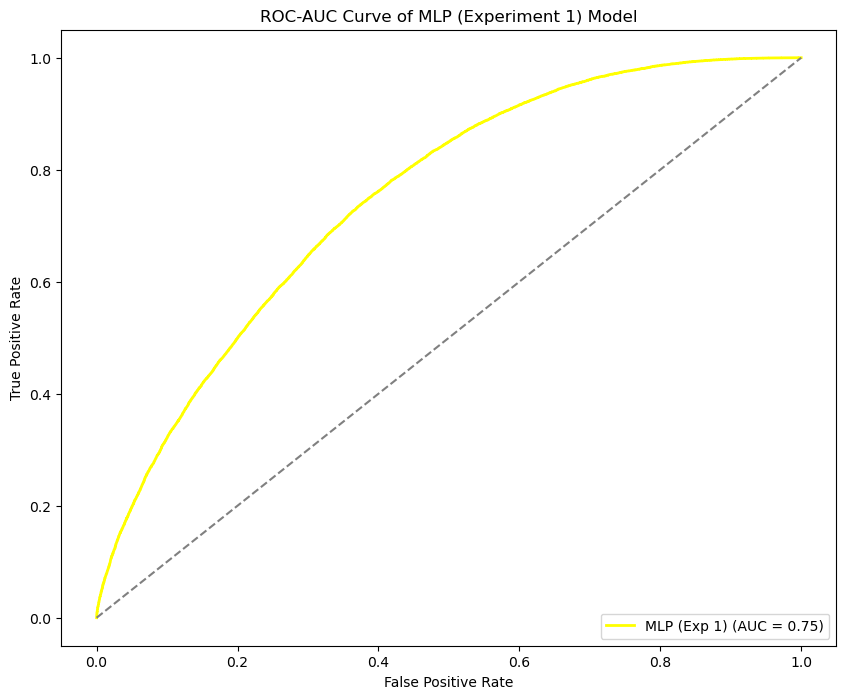

In [265]:
mlp_E1_y_prob = mlp_E1_best_model.predict_proba(X_test_scaled)[:,1]

mlp_E1_fpr, mlp_E1_tpr, _ = roc_curve(y_test, mlp_E1_y_prob)

mlp_E1_auc = auc(mlp_E1_fpr, mlp_E1_tpr)

# Plot the ROC - AUC Curve of MLP (Experiment 1)
plt.figure(figsize = (10,8))
plt.plot(mlp_E1_fpr, mlp_E1_tpr, label = f"MLP (Exp 1) (AUC = {mlp_E1_auc:.2f})", color = "yellow", lw = 2)
plt.plot([0,1], [0,1], color = "gray", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve of MLP (Experiment 1) Model")
plt.legend(loc = "lower right")
plt.show()

(e) Confusion Matrix

In [232]:
# Confusion Matrix for Test Set of MLP (Experiment 1)
mlp_E1_test_CM = confusion_matrix(y_test, mlp_E1_y_test_pred)

# Print the Extracted Values
mlp_E1_TN, mlp_E1_FP, mlp_E1_FN, mlp_E1_TP = mlp_E1_test_CM.ravel()

print("Confusion Matrix of MLP (Experiment 1) Model")
print(" ")
print("True Positives (TP): {}".format(mlp_E1_TP))
print(" ")
print("False Positives (FP): {}".format(mlp_E1_FP))
print(" ")
print("True Negatives (TN): {}".format(mlp_E1_TN))
print(" ")
print("False Negatives (FN): {}".format(mlp_E1_FN))

Confusion Matrix of MLP (Experiment 1) Model
 
True Positives (TP): 29911
 
False Positives (FP): 26323
 
True Negatives (TN): 7558
 
False Negatives (FN): 582


<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 14.722222222222216, 'Predicted Label')

Text(33.222222222222214, 0.5, 'Actual Label')

Text(0.5, 1.0, 'Confusion Matrix of MLP (Experiment 1) Model')

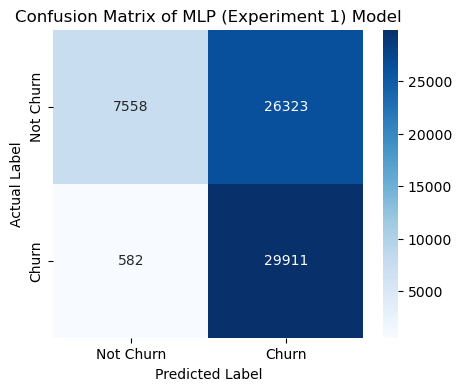

In [234]:
# Plot the Confusion Matrix for Test Set of MLP (Experiment 1)
plt.figure(figsize = (5,4))
sns.heatmap(mlp_E1_test_CM, annot = True, fmt = "d", cmap = "Blues",
            xticklabels = ["Not Churn", "Churn"], yticklabels = ["Not Churn", "Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix of MLP (Experiment 1) Model")
plt.show()

**Experiment 2**
<ul>
    <li>hidden_layer_sizes : (64,), (128,)</li>
    <li>activation : relu</li>
    <li>solver : adam</li>
    <li>alpha : 100.0, 500.0, 1000.0</li>
    <li>max_iter : 500, 1000</li>
</ul>

(a) Initializing the Model

In [246]:
# Initialize MLP Model (Experiment 2)
mlp_E2 = MLPClassifier(random_state = 42, early_stopping=True, learning_rate_init=0.001)

# Define the hyperparameter 2
mlp_E2_param = {
                "hidden_layer_sizes" : [(64,), (128,)],
                "activation" : ["relu"],
                "solver" : ["adam"],
                "alpha" : [100, 500, 1000],
                "max_iter" : [500, 1000]
                }

# Grid Search Cross Validation
mlp_E2_grid = GridSearchCV(mlp_E2, param_grid = mlp_E2_param, cv = 3, scoring = "accuracy",
                              n_jobs = -1, verbose = 2, return_train_score = True)

# Fit the Model
mlp_E2_grid.fit(X_train_scaled, y_train_balanced)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=MLPClassifier(early_stopping=True, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [100, 500, 1000],
                         'hidden_layer_sizes': [(64,), (128,)],
                         'max_iter': [500, 1000], 'solver': ['adam']},
             return_train_score=True, scoring='accuracy', verbose=2)

(b) Best Parameter and Best Model

In [248]:
# Best Parameter of MLP Model (Experiment 2)
mlp_E2_best_param = mlp_E2_grid.best_params_
print("Best Parameter of MLP Model (Experiment 2): {}".format(mlp_E2_best_param))

# Best Model of MLP Model (Experiment 2)
mlp_E2_best_model = mlp_E2_grid.best_estimator_

Best Parameter of MLP Model (Experiment 2): {'activation': 'relu', 'alpha': 100, 'hidden_layer_sizes': (128,), 'max_iter': 500, 'solver': 'adam'}


(c) Evaluating the Model

In [250]:
# MLP (Experiment 2) - Model Evaluation on Training Set

# Prediction on Training Data
mlp_E2_y_train_pred = mlp_E2_best_model.predict(X_train_scaled)

# Accuracy of Training Set
mlp_E2_train_acc = accuracy_score(y_train_balanced, mlp_E2_y_train_pred)

# Classification Report of Training Set
mlp_E2_train_CR = classification_report(y_train_balanced, mlp_E2_y_train_pred)

# Print the Result of Training Set
print("MLP Model (Experiment 2) Result on Training Data")
print(" ")
print("MLP Model (Experiment 2) Accuracy (Training Set): {}".format(mlp_E2_train_acc))
print(" ")
print("MLP Model (Experiment 2) Classification Report (Training Set): \n", mlp_E2_train_CR)

MLP Model (Experiment 2) Result on Training Data
 
MLP Model (Experiment 2) Accuracy (Training Set): 0.8930335721342886
 
MLP Model (Experiment 2) Classification Report (Training Set): 
               precision    recall  f1-score   support

           0       0.86      0.93      0.90    249999
           1       0.93      0.85      0.89    249999

    accuracy                           0.89    499998
   macro avg       0.90      0.89      0.89    499998
weighted avg       0.90      0.89      0.89    499998



In [252]:
# Compute the Churn Probabilities
mlp_E2_y_prob = mlp_E2_best_model.predict_proba(X_test_scaled)[:,1]

# Compute Precision-Recall Vs. Threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, mlp_E2_y_prob)

# Find the Optimal Threshold (Where Precision ~ Recall)
optimal_idx = np.argmin(np.abs(precisions - recalls))
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold for MLP (Experiment 2) Model: {}".format(optimal_threshold))

Optimal Threshold for MLP (Experiment 2) Model: 0.5144618021065089


In [254]:
# MLP (Experiment 2) - Model Evaluation on Test Set

# Prediction on Test Data with adjusted Threshold
mlp_E2_y_test_pred = (mlp_E2_y_prob >= optimal_threshold).astype(int)

# Accuracy of Test Set
mlp_E2_test_acc = accuracy_score(y_test, mlp_E2_y_test_pred)

# Classification Report of Test Set
mlp_E2_test_CR = classification_report(y_test, mlp_E2_y_test_pred)

# Print the Result of Test Set
print("MLP Model (Experiment 2) Result on Test Data")
print(" ")
print("MLP Model (Experiment 2) Accuracy (Test Set): {}".format(mlp_E2_test_acc))
print(" ")
print("MLP Model (Experiment 2) Classification Report (Test Set): \n", mlp_E2_test_CR)

MLP Model (Experiment 2) Result on Test Data
 
MLP Model (Experiment 2) Accuracy (Test Set): 0.6713269332339143
 
MLP Model (Experiment 2) Classification Report (Test Set): 
               precision    recall  f1-score   support

           0       0.69      0.69      0.69     33881
           1       0.65      0.65      0.65     30493

    accuracy                           0.67     64374
   macro avg       0.67      0.67      0.67     64374
weighted avg       0.67      0.67      0.67     64374



(d) ROC - AUC Curve

<Figure size 1000x800 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC-AUC Curve of MLP (Experiment 2) Model')

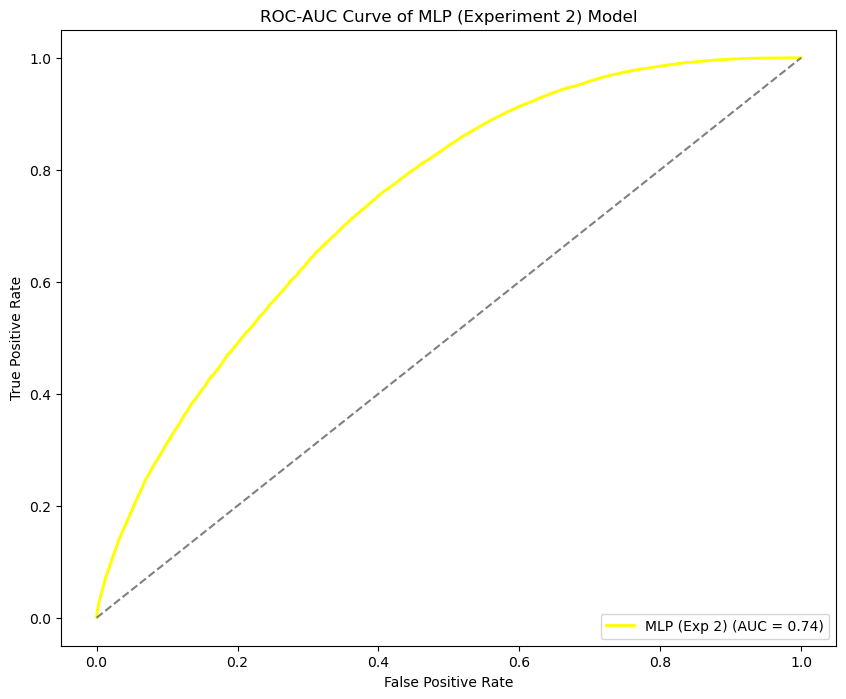

In [267]:
mlp_E2_fpr, mlp_E2_tpr, _ = roc_curve(y_test, mlp_E2_y_prob)

mlp_E2_auc = auc(mlp_E2_fpr, mlp_E2_tpr)

# Plot the ROC - AUC Curve of MLP (Experiment 2)
plt.figure(figsize = (10,8))
plt.plot(mlp_E2_fpr, mlp_E2_tpr, label = f"MLP (Exp 2) (AUC = {mlp_E2_auc:.2f})", color = "yellow", lw = 2)
plt.plot([0,1], [0,1], color = "gray", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve of MLP (Experiment 2) Model")
plt.legend(loc = "lower right")
plt.show()

(e) Confusion Matrix

In [258]:
# Confusion Matrix for Test Set of MLP (Experiment 2)
mlp_E2_test_CM = confusion_matrix(y_test, mlp_E2_y_test_pred)

# Print the Extracted Values
mlp_E2_TN, mlp_E2_FP, mlp_E2_FN, mlp_E2_TP = mlp_E2_test_CM.ravel()

print("Confusion Matrix of MLP (Experiment 2) Model")
print(" ")
print("True Positives (TP): {}".format(mlp_E2_TP))
print(" ")
print("False Positives (FP): {}".format(mlp_E2_FP))
print(" ")
print("True Negatives (TN): {}".format(mlp_E2_TN))
print(" ")
print("False Negatives (FN): {}".format(mlp_E2_FN))

Confusion Matrix of MLP (Experiment 2) Model
 
True Positives (TP): 19914
 
False Positives (FP): 10579
 
True Negatives (TN): 23302
 
False Negatives (FN): 10579


<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 14.722222222222216, 'Predicted Label')

Text(33.222222222222214, 0.5, 'Actual Label')

Text(0.5, 1.0, 'Confusion Matrix of MLP (Experiment 2) Model')

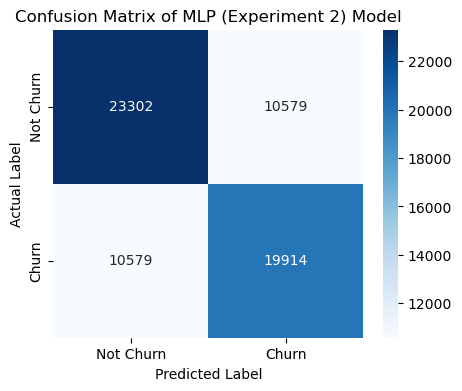

In [260]:
# Plot the Confusion Matrix for Test Set of MLP (Experiment 2)
plt.figure(figsize = (5,4))
sns.heatmap(mlp_E2_test_CM, annot = True, fmt = "d", cmap = "Blues",
            xticklabels = ["Not Churn", "Churn"], yticklabels = ["Not Churn", "Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix of MLP (Experiment 2) Model")
plt.show()

**Conclusions**

The MLP model demonstrated strong learning ability but exhibited signs of overfitting to the training data, as indicated by the high training accuracy (89%) and a lower test accuracy (67%). Adjusting the decision threshold improved test accuracy slightly. The ROC-AUC of 0.74 indicates a better trade-off between sensitivity and specificity compared to previous models.